# **Import libraries**





In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import plotly.express as px
from datetime import date
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation
from statsmodels.tsa.api import SARIMAX
from IPython.display import clear_output
from math import pow
from math import ceil
import plotly.express as px
import random
import plotly.graph_objects as go

# **Load data**







Connect Drive

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
beginInv = pd.read_csv("/content/drive/MyDrive/Data/BegInvFINAL12312016.csv")
endInv = pd.read_csv("/content/drive/MyDrive/Data/EndInvFINAL12312016.csv")
invPurchase = pd.read_csv("/content/drive/MyDrive/Data/InvoicePurchases12312016.csv")
purchase = pd.read_csv("/content/drive/MyDrive/Data/PurchasesFINAL12312016.csv")
purchasePrice = pd.read_csv("/content/drive/MyDrive/Data/2017PurchasePricesDec.csv")
sales = pd.read_csv("/content/drive/MyDrive/Data/SalesFINAL12312016.csv")

# **EDA**

## **Inventory analysis**

In [ ]:
print(beginInv)

               InventoryId  Store          City  Brand  \
0        1_HARDERSFIELD_58      1  HARDERSFIELD     58   
1        1_HARDERSFIELD_60      1  HARDERSFIELD     60   
2        1_HARDERSFIELD_62      1  HARDERSFIELD     62   
3        1_HARDERSFIELD_63      1  HARDERSFIELD     63   
4        1_HARDERSFIELD_72      1  HARDERSFIELD     72   
...                    ...    ...           ...    ...   
206524  79_BALLYMENA_46985     79     BALLYMENA  46985   
206525  79_BALLYMENA_47014     79     BALLYMENA  47014   
206526  79_BALLYMENA_47090     79     BALLYMENA  47090   
206527  79_BALLYMENA_90011     79     BALLYMENA  90011   
206528  79_BALLYMENA_90089     79     BALLYMENA  90089   

                         Description   Size  onHand  Price   startDate  
0        Gekkeikan Black & Gold Sake  750mL       8  12.99  2016-01-01  
1             Canadian Club 1858 VAP  750mL       7  10.99  2016-01-01  
2           Herradura Silver Tequila  750mL       6  36.99  2016-01-01  
3         H

In [ ]:
print(endInv)

              InventoryId  Store          City  Brand  \
0       1_HARDERSFIELD_58      1  HARDERSFIELD     58   
1       1_HARDERSFIELD_62      1  HARDERSFIELD     62   
2       1_HARDERSFIELD_63      1  HARDERSFIELD     63   
3       1_HARDERSFIELD_72      1  HARDERSFIELD     72   
4       1_HARDERSFIELD_75      1  HARDERSFIELD     75   
...                   ...    ...           ...    ...   
224484  81_PEMBROKE_90087     81      PEMBROKE  90087   
224485  81_PEMBROKE_90088     81      PEMBROKE  90088   
224486  81_PEMBROKE_90089     81      PEMBROKE  90089   
224487  81_PEMBROKE_90090     81      PEMBROKE  90090   
224488  81_PEMBROKE_90604     81      PEMBROKE  90604   

                         Description   Size  onHand  Price     endDate  
0        Gekkeikan Black & Gold Sake  750mL      11  12.99  2016-12-31  
1           Herradura Silver Tequila  750mL       7  36.99  2016-12-31  
2         Herradura Reposado Tequila  750mL       7  38.99  2016-12-31  
3               No. 3 L

In [ ]:
distinct_count = beginInv['InventoryId'].nunique()
print(distinct_count)
distinct_count_1 = endInv['InventoryId'].nunique()
print(distinct_count_1)

206529
224489


In [ ]:
inventory = pd.merge(
    beginInv[['InventoryId', 'onHand']],
    endInv[['InventoryId', 'onHand']],
    on='InventoryId',
    how='outer',
    suffixes=('_begin', '_end')
)

inventory.columns = ['InventoryID', 'Onhand_begin', 'Onhand_end']
inventory['Onhand_begin'] = inventory['Onhand_begin'].fillna(0)
inventory['Onhand_end'] = inventory['Onhand_end'].fillna(0)
print(inventory)


             InventoryID  Onhand_begin  Onhand_end
0        10_HORNSEY_1000          1.00        0.00
1        10_HORNSEY_1001         11.00        0.00
2        10_HORNSEY_1003          0.00       73.00
3        10_HORNSEY_1005         18.00        0.00
4       10_HORNSEY_10058         52.00       24.00
...                  ...           ...         ...
256037  9_BLACKPOOL_9388          7.00        4.00
256038   9_BLACKPOOL_942          0.00        2.00
256039   9_BLACKPOOL_966          8.00        9.00
256040   9_BLACKPOOL_984         23.00        5.00
256041   9_BLACKPOOL_999          0.00        0.00

[256042 rows x 3 columns]


In [ ]:
inventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256042 entries, 0 to 256041
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   InventoryID   256042 non-null  object 
 1   Onhand_begin  256042 non-null  float64
 2   Onhand_end    256042 non-null  float64
dtypes: float64(2), object(1)
memory usage: 5.9+ MB


### **Description for begin inventory**

In [ ]:
description = inventory['Onhand_begin'].describe()
print(description)

count   256042.00
mean        16.48
std         29.39
min          0.00
25%          3.00
50%          9.00
75%         18.00
max       1251.00
Name: Onhand_begin, dtype: float64


### **Desscription for end inventory**

In [ ]:
description_1 = inventory['Onhand_end'].describe()
print(description_1)

count   256042.00
mean        19.08
std         35.59
min          0.00
25%          5.00
50%         11.00
75%         20.00
max       3676.00
Name: Onhand_end, dtype: float64


In [ ]:
filtered_rows= inventory[(inventory['Onhand_begin']==0) & (inventory['Onhand_end']>0)]
print(filtered_rows)

              InventoryID  Onhand_begin  Onhand_end
2         10_HORNSEY_1003          0.00       73.00
11        10_HORNSEY_1019          0.00       11.00
23        10_HORNSEY_1028          0.00        9.00
24       10_HORNSEY_10283          0.00       36.00
31        10_HORNSEY_1036          0.00        1.00
...                   ...           ...         ...
255999   9_BLACKPOOL_8828          0.00        4.00
256004   9_BLACKPOOL_8848          0.00        8.00
256026  9_BLACKPOOL_90631          0.00        5.00
256031   9_BLACKPOOL_9160          0.00        1.00
256038    9_BLACKPOOL_942          0.00        2.00

[48917 rows x 3 columns]


Calculate quantity change between beginning inventory and ending inventory

In [ ]:
inventory['quantity_change'] = inventory['Onhand_end']-inventory['Onhand_begin']
print(inventory)

             InventoryID  Onhand_begin  Onhand_end  quantity_change
0        10_HORNSEY_1000          1.00        0.00            -1.00
1        10_HORNSEY_1001         11.00        0.00           -11.00
2        10_HORNSEY_1003          0.00       73.00            73.00
3        10_HORNSEY_1005         18.00        0.00           -18.00
4       10_HORNSEY_10058         52.00       24.00           -28.00
...                  ...           ...         ...              ...
256037  9_BLACKPOOL_9388          7.00        4.00            -3.00
256038   9_BLACKPOOL_942          0.00        2.00             2.00
256039   9_BLACKPOOL_966          8.00        9.00             1.00
256040   9_BLACKPOOL_984         23.00        5.00           -18.00
256041   9_BLACKPOOL_999          0.00        0.00             0.00

[256042 rows x 4 columns]


### **Statistic Descriptive for Quantity Change**

In [ ]:
description_2 = inventory['quantity_change'].describe()
print(description_2)

count   256042.00
mean         2.60
std         31.65
min       -823.00
25%         -5.00
50%          1.00
75%          8.00
max       3676.00
Name: quantity_change, dtype: float64


Quantity Change boxplot

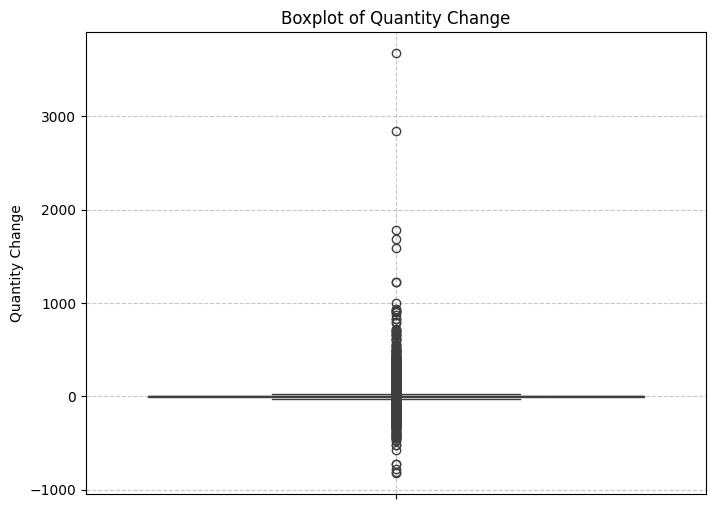

In [ ]:
plt.figure(figsize=(8,6))
box = sns.boxplot(y=inventory['quantity_change'])

plt.title('Boxplot of Quantity Change')
plt.ylabel('Quantity Change')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

##**Sales Analysis**


In [ ]:
print(sales)

                 InventoryId  Store  Brand                 Description  \
0        1_HARDERSFIELD_1004      1   1004  Jim Beam w/2 Rocks Glasses   
1        1_HARDERSFIELD_1004      1   1004  Jim Beam w/2 Rocks Glasses   
2        1_HARDERSFIELD_1004      1   1004  Jim Beam w/2 Rocks Glasses   
3        1_HARDERSFIELD_1004      1   1004  Jim Beam w/2 Rocks Glasses   
4        1_HARDERSFIELD_1005      1   1005     Maker's Mark Combo Pack   
...                      ...    ...    ...                         ...   
1048570  19_WINTERVALE_39384     19  39384    F Coppola Diamond Pnt Nr   
1048571  19_WINTERVALE_39384     19  39384    F Coppola Diamond Pnt Nr   
1048572  19_WINTERVALE_39384     19  39384    F Coppola Diamond Pnt Nr   
1048573  19_WINTERVALE_39384     19  39384    F Coppola Diamond Pnt Nr   
1048574  19_WINTERVALE_39384     19  39384    F Coppola Diamond Pnt Nr   

               Size  SalesQuantity  SalesDollars  SalesPrice  SalesDate  \
0             750mL              1  

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   InventoryId     1048575 non-null  object 
 1   Store           1048575 non-null  int64  
 2   Brand           1048575 non-null  int64  
 3   Description     1048575 non-null  object 
 4   Size            1048575 non-null  object 
 5   SalesQuantity   1048575 non-null  int64  
 6   SalesDollars    1048575 non-null  float64
 7   SalesPrice      1048575 non-null  float64
 8   SalesDate       1048575 non-null  object 
 9   Volume          1048575 non-null  int64  
 10  Classification  1048575 non-null  int64  
 11  ExciseTax       1048575 non-null  float64
 12  VendorNo        1048575 non-null  int64  
 13  VendorName      1048575 non-null  object 
dtypes: float64(3), int64(6), object(5)
memory usage: 112.0+ MB


    SalesDate  SalesQuantity
0  2016-01-01          49911
1  2016-01-02          93114
2  2016-01-03          53037
3  2016-01-04          41341
4  2016-01-05          40831
5  2016-01-06          51358
6  2016-01-07          59792
7  2016-01-08          97389
8  2016-01-09         101690
9  2016-01-10          46146
10 2016-01-11          44654
11 2016-01-12          49803
12 2016-01-13          48556
13 2016-01-14          64830
14 2016-01-15         107858
15 2016-01-16          98860
16 2016-01-17          66170
17 2016-01-18          48512
18 2016-01-19          49128
19 2016-01-20          53132
20 2016-01-21          70333
21 2016-01-22         107974
22 2016-01-23         106146
23 2016-01-24          59926
24 2016-01-25          41917
25 2016-01-26          48505
26 2016-01-27          54176
27 2016-01-28          69222
28 2016-01-29         180426
29 2016-01-30         117456
30 2016-01-31          72766
31 2016-02-01           5771
32 2016-02-02           6529
33 2016-02-03 

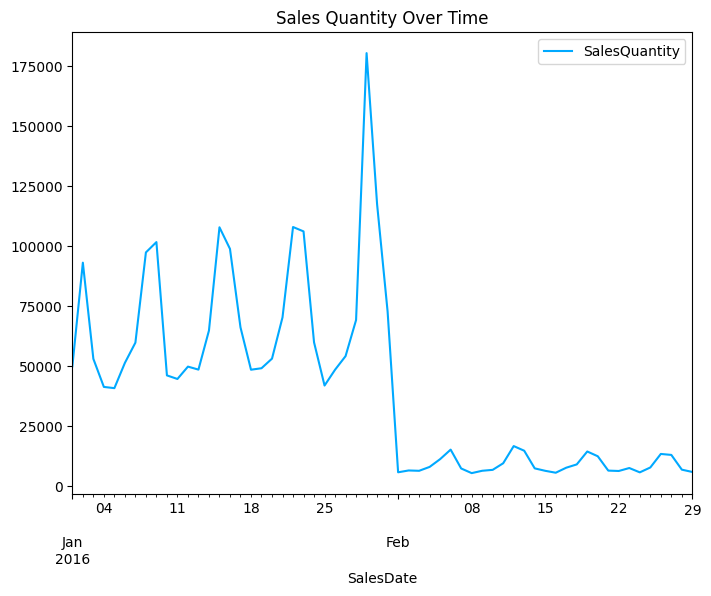

In [ ]:
sales['SalesDate']=pd.to_datetime(sales['SalesDate'])
salesquantity_trend=sales.groupby('SalesDate').agg({'SalesQuantity':'sum'}).reset_index()
print(salesquantity_trend)
salequantity_trend_plot = salesquantity_trend.plot(x='SalesDate',y='SalesQuantity',title="Sales Quantity Over Time",figsize=(8,6),color="#00A9FF")

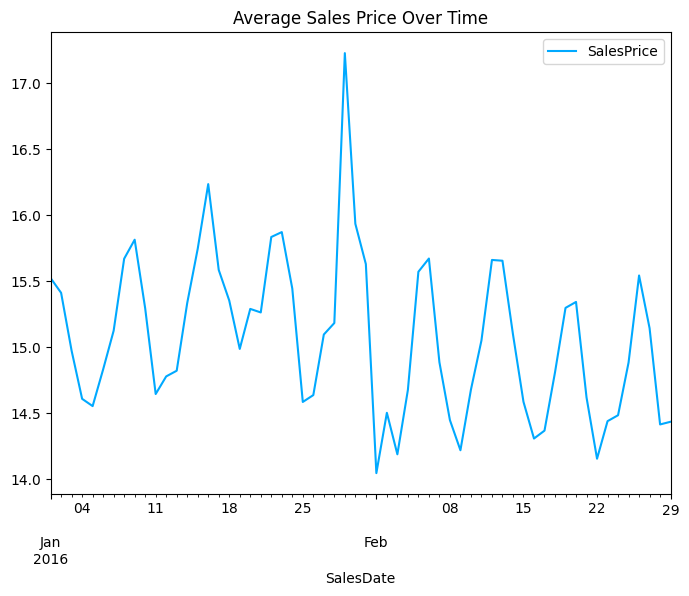

In [ ]:
avg_price_trend = sales.groupby('SalesDate').agg('SalesPrice').mean().reset_index()
avg_price_trend_plot = avg_price_trend.plot(x='SalesDate', y='SalesPrice', title="Average Sales Price Over Time",figsize=(8,6),color="#00A9FF")

## **Overview Purchase Analysis**

In [ ]:
description_3 =purchase['Quantity'].describe()
formatted_description = description_3.apply(lambda x: f"{x:,.2f}")

# Hiển thị kết quả đã định dạng
print(formatted_description)


count    2,372,474.00
mean            14.16
std             23.45
min              1.00
25%              6.00
50%             10.00
75%             12.00
max          3,816.00
Name: Quantity, dtype: object


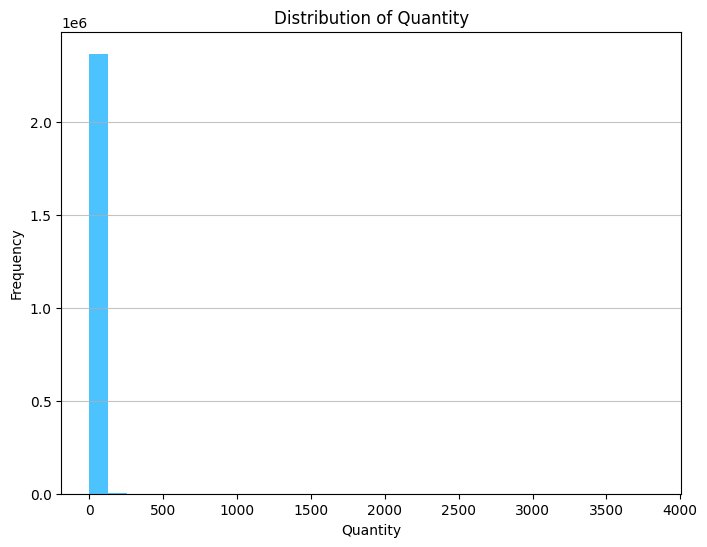

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(purchase['Quantity'], bins=30, color='#00A9FF', alpha=0.7)
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

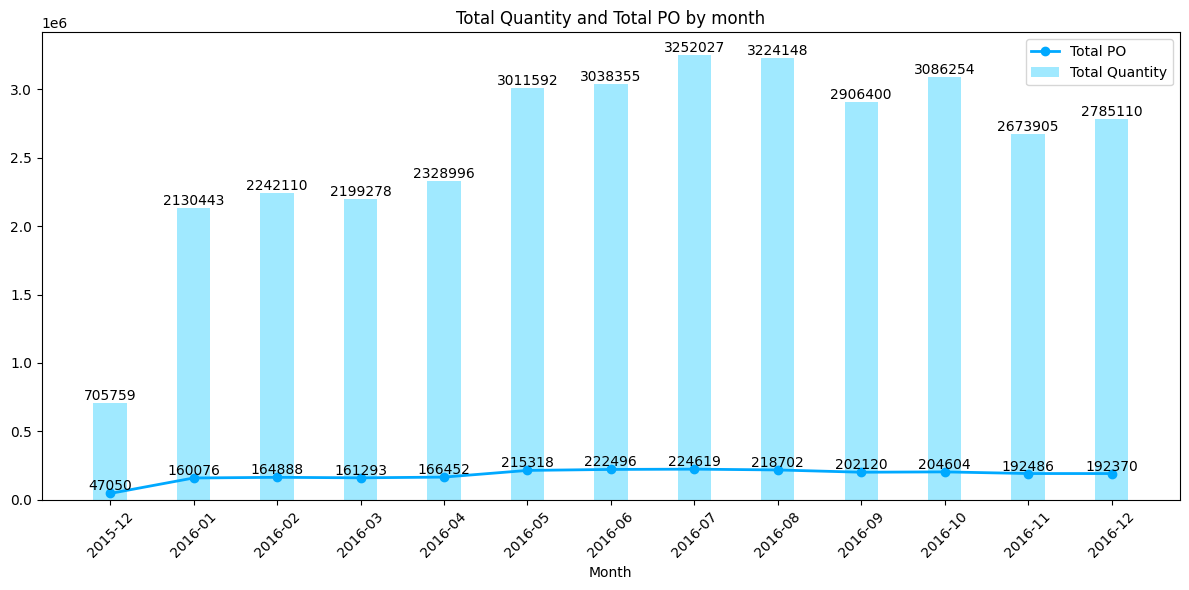

In [ ]:
purchase['PODate']=pd.to_datetime(purchase['PODate'])
purchase_month= purchase['PODate'].dt.to_period('M')

purchase_trend = purchase.groupby(purchase_month).agg(
    TotalPO=('PONumber','count'),
    TotalQuantity=('Quantity','sum')).reset_index()

purchase_trend['purchase_month'] = purchase_trend['PODate'].astype(str)


plt.figure(figsize=(12,6))
#Create posistion for columns
index =range(len(purchase_trend['purchase_month']))
#Bar chary for Total PO
bars=plt.bar(index,purchase_trend['TotalQuantity'],width=0.4,label='Total Quantity',color='#A0E9FF')

# Line chart for Total Quantity
plt.plot(index,purchase_trend['TotalPO'],label='Total PO', color ='#00A9FF' , marker ='o', linewidth =2)

# Thêm nhãn dữ liệu cho cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

# Thêm nhãn dữ liệu cho đường
for i, value in enumerate(purchase_trend['TotalPO']):
    plt.text(i, value, int(value), va='bottom', ha='center')

# Đặt tiêu đề và nhãn
plt.title('Total Quantity and Total PO by month')
plt.xlabel('Month')
plt.xticks(index, purchase_trend['purchase_month'], rotation=45)
plt.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

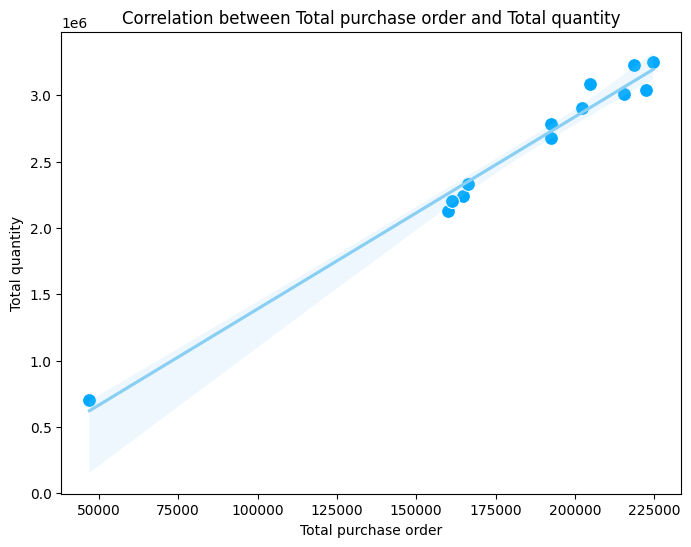

In [ ]:
plt.figure(figsize=(8,6))
# Create a scatter plot to visualize the correlation
sns.scatterplot(data=purchase_trend,x='TotalPO',y='TotalQuantity',color='#00A9FF',s=100)
# Add a regression line for better understanding of the correlation
sns.regplot(data=purchase_trend, x='TotalPO', y='TotalQuantity', scatter= False,color='#89CFF3')
# Set the title and labels
plt.title('Correlation between Total purchase order and Total quantity')
plt.xlabel('Total purchase order')
plt.ylabel('Total quantity')
plt.grid(False)
plt.show()







BD: EDA hình như chưa có Identifying potential data issues trong file code á

# **Preprocessing Data**

## **Handling missing values**


In [ ]:
def analyze_data_quality(*data_sets):

    datasets = []
    missing_values_counts = []
    duplicate_counts = []
    missing_value_details = []


    for name, data in data_sets:
        missing_values = {}
        # Analyze missing values
        for col in data.columns:
            null_count = data[col].isnull().sum()
            if null_count > 0:
                missing_values[col] = null_count

        # Count duplicates
        duplicates = data[data.duplicated()]
        duplicate_count = len(duplicates)

        # Collect data for summary
        datasets.append(name)
        missing_values_counts.append(sum(missing_values.values()))  # Total missing values for the dataset
        duplicate_counts.append(duplicate_count)

        # Collect missing value
        missing_value_details.append(missing_values)

    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'Dataset': datasets,
        'Total Missing Values': missing_values_counts,
        'Total Duplicate Records': duplicate_counts,
        'Missing Value Details': missing_value_details
    })

    print(summary_df.to_string(index=False))

In [ ]:
analyze_data_quality(("Beginning Inventory", beginInv),
            ("Ending Inventory", endInv),
            ("Purchase", purchase),
            ("Purchase Invoices", invPurchase),
            ("Purchase Price", purchasePrice),
            ("Sales", sales))

            Dataset  Total Missing Values  Total Duplicate Records                      Missing Value Details
Beginning Inventory                     0                        0                                         {}
   Ending Inventory                  1284                        0                             {'City': 1284}
           Purchase                     3                        0                                {'Size': 3}
  Purchase Invoices                  5169                        0                         {'Approval': 5169}
     Purchase Price                     3                        0 {'Description': 1, 'Size': 1, 'Volume': 1}
              Sales                     0                        0                                         {}


In [ ]:
beginInv_df = beginInv.copy()
endInv_df = endInv.copy()
purchase_df = purchase.copy()
invPurchase_df= invPurchase.copy()
purchasePrice_df = purchasePrice.copy()
sales_df = sales.copy()

#Handling Missing Values in Ending Inventory of Column "City"
endInv_df["City"] = endInv_df["City"].fillna("TYWARDREATH")

#Handling Missing Values in Purchase table of Column "Size"
purchase_df["Size"] = purchase_df["Size"].ffill()

#Handling Missing Values in the "Approval" Column of the Purchase Invoice Table
invPurchase_df = invPurchase_df.drop(['Approval'], axis=1)


#Handling Missing  Values in the Purchase Price Table
purchasePrice_df.dropna(subset=["Description"], inplace=True)
purchasePrice_df = purchasePrice_df[purchasePrice_df["Size"] != "Unknown"]
purchasePrice_df = purchasePrice_df.drop(["Volume"], axis=1)

In [ ]:
def summarize_missing_values(*dataframes):
    for name, df in dataframes:
        missing_count = {}
        for col in df.columns:
            count = df[col].isnull().sum()
            if count > 0:
                missing_count[col] = count

        if not missing_count:
            print(f"No missing values in {name}.")
        else:
            for col, count in missing_count.items():
                print(f"In {name}: Column '{col}' has {count} missing values.")


In [ ]:
print("\n Summary of missing values")  # newline between outputs

# Call the function with original DataFrames
summarize_missing_values(
    ("Beginning Inventory", beginInv_df),
    ("Ending Inventory", endInv_df),
    ("Purchases", purchase_df),
    ("Purchases Invoice", invPurchase_df),
    ("Purchase Price", purchasePrice_df),
    ("Sales", sales_df))


 Summary of missing values
No missing values in Beginning Inventory.
No missing values in Ending Inventory.
No missing values in Purchases.
No missing values in Purchases Invoice.
No missing values in Purchase Price.
No missing values in Sales.


## **Handling Irregularities in Data Entries**

### **Format Size Columns**

In [ ]:
datasets = [beginInv_df, endInv_df, purchase_df, purchasePrice_df, sales_df]
# Combine sizes from all datasets into a single Series
all_sizes_combined = pd.concat([df['Size'] for df in datasets])

# Get unique sizes
unique_sizes_list = all_sizes_combined.unique()

# Count occurrences of each unique size
size_count_dict = {size: all_sizes_combined[all_sizes_combined == size].count() for size in unique_sizes_list}

# Create a DataFrame to hold the unique sizes and their counts
unique_sizes_df = pd.DataFrame({
    'Size': unique_sizes_list,
    'Total Count': [size_count_dict[size] for size in unique_sizes_list]
})

In [ ]:
print(unique_sizes_df.head(50))

          Size  Total Count
0        750mL      2113365
1        Liter        73920
2        1.75L       809721
3         50mL       195549
4        375mL       139094
5    50mL 4 Pk         2056
6   375mL 2 Pk          544
7   750mL 3 Pk          153
8   375mL 3 Pk           89
9   750mL + 3/          286
10  200mL 3 Pk          479
11   50mL 3 Pk          863
12  100mL 4 Pk         2220
13       100mL         3773
14   50mL 5 Pk         2215
15  200mL 4 Pk         1903
16  250mL 4 Pk         2068
17  750mL 2 Pk          628
18       200mL         3386
19     3/100mL          514
20        1.5L       322129
21          5L        69059
22          4L         8288
23  187mL 4 Pk        16693
24          3L        71949
25      5.0 Oz          607
26       187mL         5023
27       500mL         9338
28  187mL 3 Pk         1586
29       300mL         1687
30  50mL 12 Pk           32
31       330mL          391
32       250mL          935
33         18L          267
34  750mL + 2/      

In [ ]:
def convert_to_liters(size):
    size = str(size).lower().strip()

    # handle pattern: 3/100ml
    if '/' in size and 'pk' not in size and '+' not in size: # Added check for '+' to avoid this pattern
        numerator, denominator = size.split('/')[0], re.split(r'[a-z]+', size.split('/')[1])[0]
        size = str(float(numerator) / float(denominator)) + "".join(re.findall(r'[a-z]+', size.split('/')[1]))
    # convert gallons and ounce to Litter
    if 'gal' in size:
        gal_value = float(re.search(r'\d+\.*\d*', size).group())
        return round(gal_value * 3.78541, 2)

    # handle pattern: "750ml +2/, 750mL 4 Pk, 187mL 4 Pk, 750mL  3"
    elif 'ml' in size:
        if 'p' in size:
            ml_value, pack_value = re.search(r'(\d+\.*\d*)\s*m*l*\s*(\d*)\s*p*/*P*k*/*', size).groups()
            ml_value = float(ml_value)
            pack_value = float(pack_value) if pack_value else 1
            return round(ml_value * pack_value / 1000, 2)  # multiply by number of packs
        elif '+' in size:
            ml_value, pack_value = map(float, re.findall(r'\d+\.*\d*', size))
            return round((ml_value + (pack_value * 50)) / 1000, 2)
        else:
            ml_value = float(re.search(r'\d+\.*\d*', size).group())
            return round(ml_value / 1000, 2)

    # convert sizes in ml to litter
    elif 'liter' in size or 'l' in size:
        if size == 'liter' or size == 'l':
            return 1.00
        else:
            liter_value = float(re.search(r'\d+\.*\d*', size).group())
            return round(liter_value, 2)
    # convert sizes in ounce to litter
    elif 'oz' in size: #Fixed indentation here
        oz_value = float(re.search(r'\d+\.*\d*', size).group())
        return round(oz_value * 0.0295735, 2)

    else:
        return None

In [ ]:
# Áp dụng hàm chuyển đổi kích thước cho từng dataframe
for i, dataset in enumerate(datasets):
    dataset['Size'] = dataset['Size'].apply(convert_to_liters)
    datasets[i] = dataset

# In các dataframe đã được chuyển đổi
for i, dataset in enumerate(datasets):
    print(f"DataFrame {i+1}:")
    print(dataset)
    print()

DataFrame 1:
               InventoryId  Store          City  Brand  \
0        1_HARDERSFIELD_58      1  HARDERSFIELD     58   
1        1_HARDERSFIELD_60      1  HARDERSFIELD     60   
2        1_HARDERSFIELD_62      1  HARDERSFIELD     62   
3        1_HARDERSFIELD_63      1  HARDERSFIELD     63   
4        1_HARDERSFIELD_72      1  HARDERSFIELD     72   
...                    ...    ...           ...    ...   
206524  79_BALLYMENA_46985     79     BALLYMENA  46985   
206525  79_BALLYMENA_47014     79     BALLYMENA  47014   
206526  79_BALLYMENA_47090     79     BALLYMENA  47090   
206527  79_BALLYMENA_90011     79     BALLYMENA  90011   
206528  79_BALLYMENA_90089     79     BALLYMENA  90089   

                         Description  Size  onHand  Price   startDate  
0        Gekkeikan Black & Gold Sake  0.75       8  12.99  2016-01-01  
1             Canadian Club 1858 VAP  0.75       7  10.99  2016-01-01  
2           Herradura Silver Tequila  0.75       6  36.99  2016-01-01  
3 

### **Format Date Columns**

In [ ]:
# Display unique date formats in specified columns
def display_original_date_formats(dataframe, *date_columns):
    for column in date_columns:
        unique_dates = dataframe[column].unique()
        print(f"Original date formats in '{column}' of the DataFrame:")
        print(unique_dates)
        print()

# Display original date formats for selected columns in the Purchase, Invoice Purchase, and Sales DataFrames
display_original_date_formats(purchase, "PODate", "ReceivingDate", "InvoiceDate", "PayDate")
display_original_date_formats(invPurchase, "InvoiceDate", "PODate", "PayDate")
display_original_date_formats(sales, "SalesDate")

Original date formats in 'PODate' of the DataFrame:
<DatetimeArray>
['2015-12-21 00:00:00', '2015-12-22 00:00:00', '2015-12-24 00:00:00',
 '2015-12-20 00:00:00', '2015-12-25 00:00:00', '2015-12-23 00:00:00',
 '2015-12-29 00:00:00', '2015-12-27 00:00:00', '2016-01-01 00:00:00',
 '2015-12-30 00:00:00',
 ...
 '2016-12-13 00:00:00', '2016-12-16 00:00:00', '2016-12-14 00:00:00',
 '2016-12-15 00:00:00', '2016-12-20 00:00:00', '2016-12-21 00:00:00',
 '2016-12-22 00:00:00', '2016-12-23 00:00:00', '2016-12-19 00:00:00',
 '2016-12-18 00:00:00']
Length: 319, dtype: datetime64[ns]

Original date formats in 'ReceivingDate' of the DataFrame:
['2016-01-02' '2016-01-01' '2016-01-03' '2016-01-04' '2016-01-07'
 '2016-01-05' '2016-01-08' '2016-01-06' '2016-01-09' '2016-01-10'
 '2016-01-11' '2016-01-13' '2016-01-15' '2016-01-14' '2016-01-12'
 '2016-01-16' '2016-01-17' '2016-01-22' '2016-01-19' '2016-01-21'
 '2016-01-20' '2016-01-18' '2016-01-23' '2016-01-24' '2016-01-29'
 '2016-01-25' '2016-01-26' '2016-0

In [ ]:
def convert_to_datetime(dataframe, *date_columns):
    for column in date_columns:
        if column in dataframe.columns:
            dataframe[column] = pd.to_datetime(dataframe[column])
    return dataframe

beginInv_df = convert_to_datetime(beginInv_df, "startDate")
endInv_df = convert_to_datetime(endInv_df, "startDate")
purchase_df = convert_to_datetime(purchase_df, "PODate", "ReceivingDate", "InvoiceDate", "PayDate")
invPurchase_df = convert_to_datetime(invPurchase_df, "InvoiceDate", "PODate", "PayDate")
sales_df = convert_to_datetime(sales_df, "SalesDate")

### **Remove Spaces**

In [ ]:
def check_spaces(dataframe, *columns):
    for column in columns:
        # Strip leading and trailing spaces and compare to original to find discrepancies
        spaces_detected = dataframe[dataframe[column] != dataframe[column].str.strip()]

        if not spaces_detected.empty:
            print(f"Issues found in '{column}':")
            print(spaces_detected[[column]].head())  # Display the first few rows with issues
        else:
            print(f"No leading or trailing spaces found in '{column}'.")

# Example usage: checking for spaces in 'City', 'Description', and 'Vendor Name' columns
check_spaces(beginInv, "City", "Description")

No leading or trailing spaces found in 'City'.
No leading or trailing spaces found in 'Description'.


In [ ]:
def trim_whitespace(dataframe, *cols):
    for col in cols:
        dataframe[col] = dataframe[col].str.strip()
    return dataframe

beginInv_df = trim_whitespace(beginInv_df, "City", "Description")
endInv_df = trim_whitespace(endInv_df, "City", "Description")
purchase_df = trim_whitespace(purchase_df, "Description", "VendorName")
invPurchase_df = trim_whitespace(invPurchase_df, "VendorName")
purchasePrice_df = trim_whitespace(purchasePrice_df, "Description", "VendorName")
sales_df = trim_whitespace(sales_df, "Description", "VendorName")

sales_df.rename(columns={'VendorNo': 'VendorNumber'}, inplace=True)


## **Analyze Ouliers**

In [ ]:
def visualize_outliers(df, columns):
    plt.figure(figsize=(15, 15))

    for i, col in enumerate(columns):
        # Box plot
        plt.subplot(4, 2, i * 2 + 1)
        sns.boxplot(data=df, x=col)
        plt.title(f'Boxplot of {col}')

        # Scatter plot
        plt.subplot(4, 2, i * 2 + 2)
        plt.scatter(df.index, df[col])
        plt.title(f'Scatter plot of {col}')
        plt.ylabel(col)
        plt.xlabel('Index')

    plt.tight_layout()
    plt.show()

# Specify the columns to visualize
columns_begin_end = ['onHand', 'Price']
columns_purinv = ['Quantity', 'Dollars', 'Freight']
columns_pur = ['Quantity', 'Dollars', 'PurchasePrice']
columns_pprice = ['Price','PurchasePrice']
columns_sales = ['SalesQuantity','SalesDollars','SalesPrice' ]

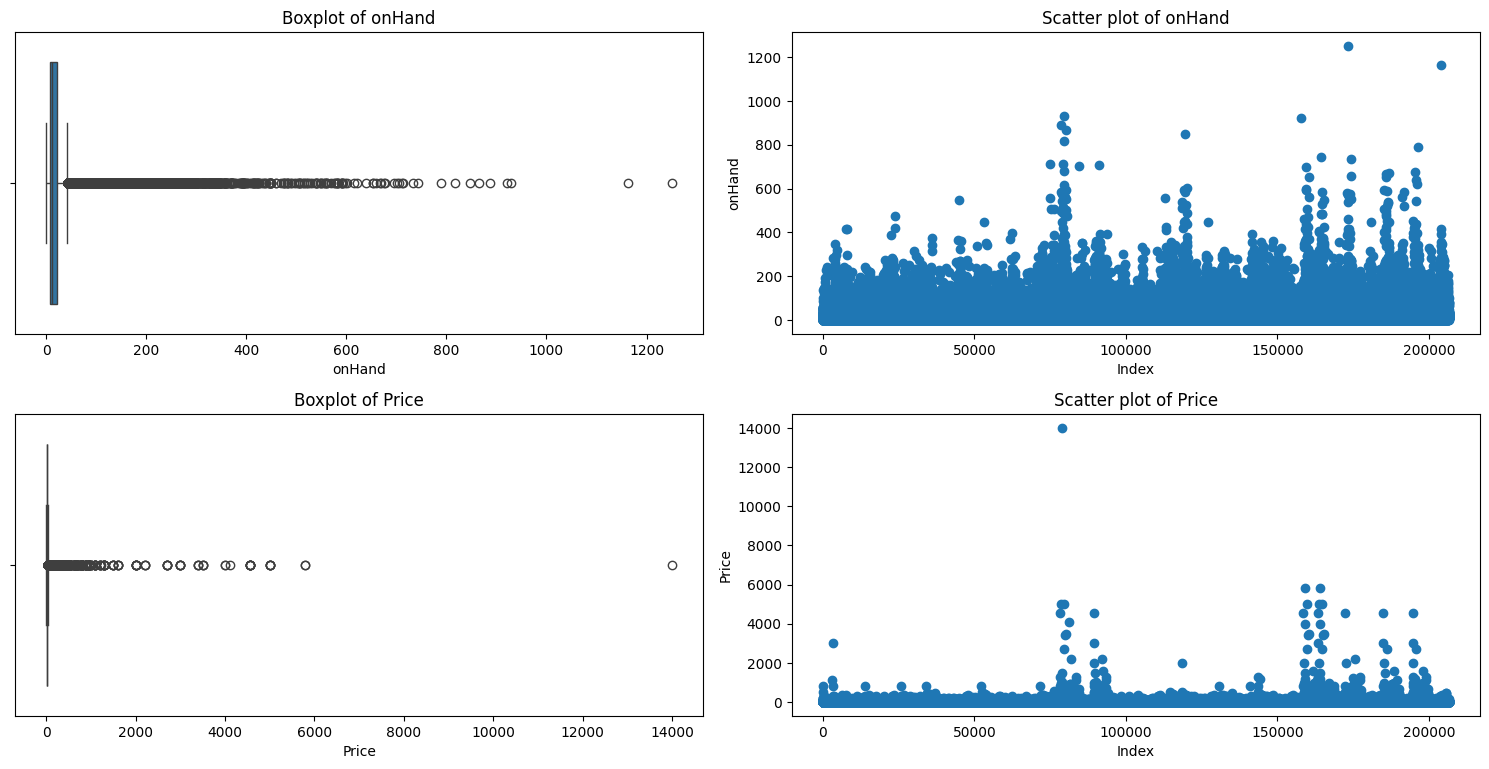

In [ ]:
visualize_outliers(beginInv_df, columns_begin_end)

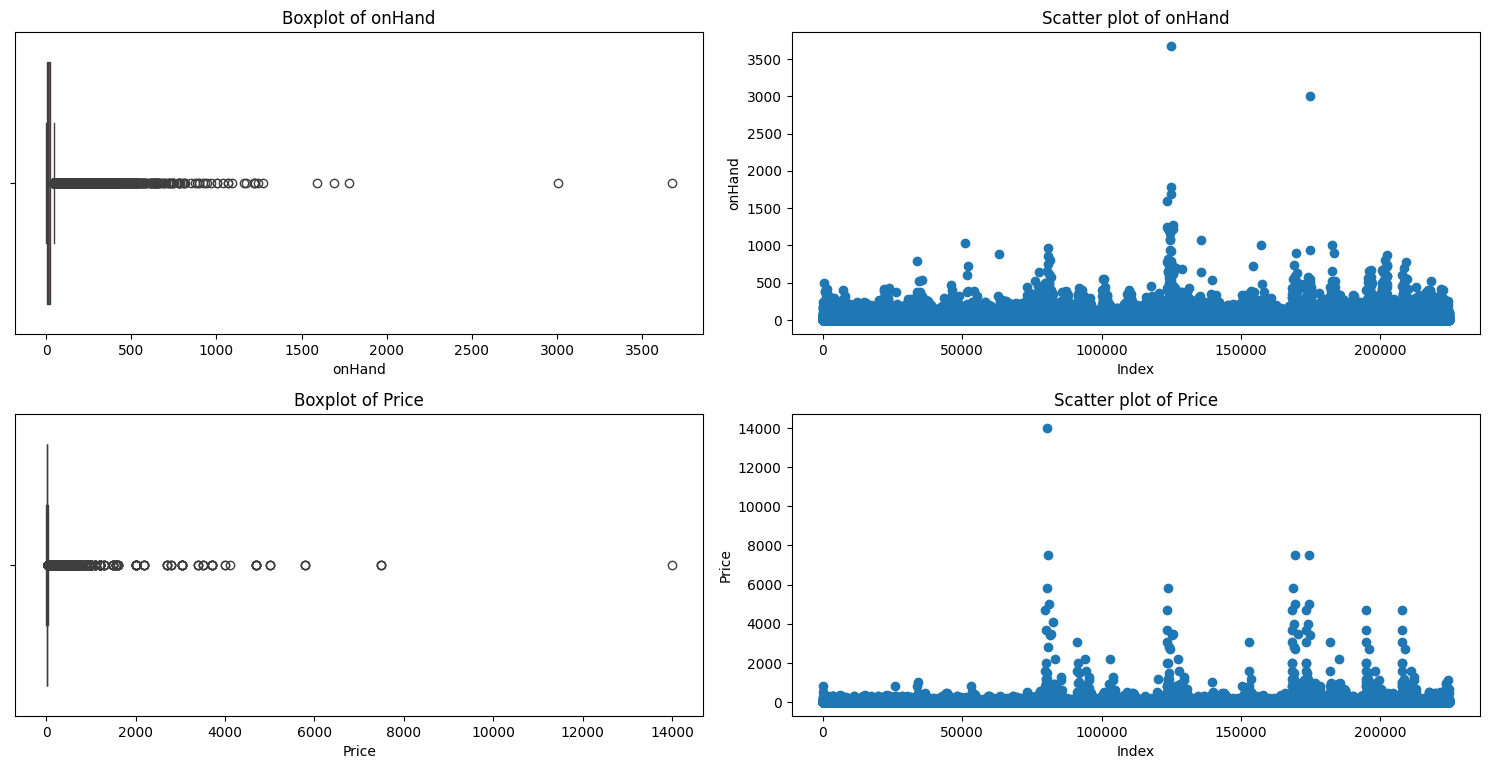

In [ ]:
visualize_outliers(endInv_df, columns_begin_end)

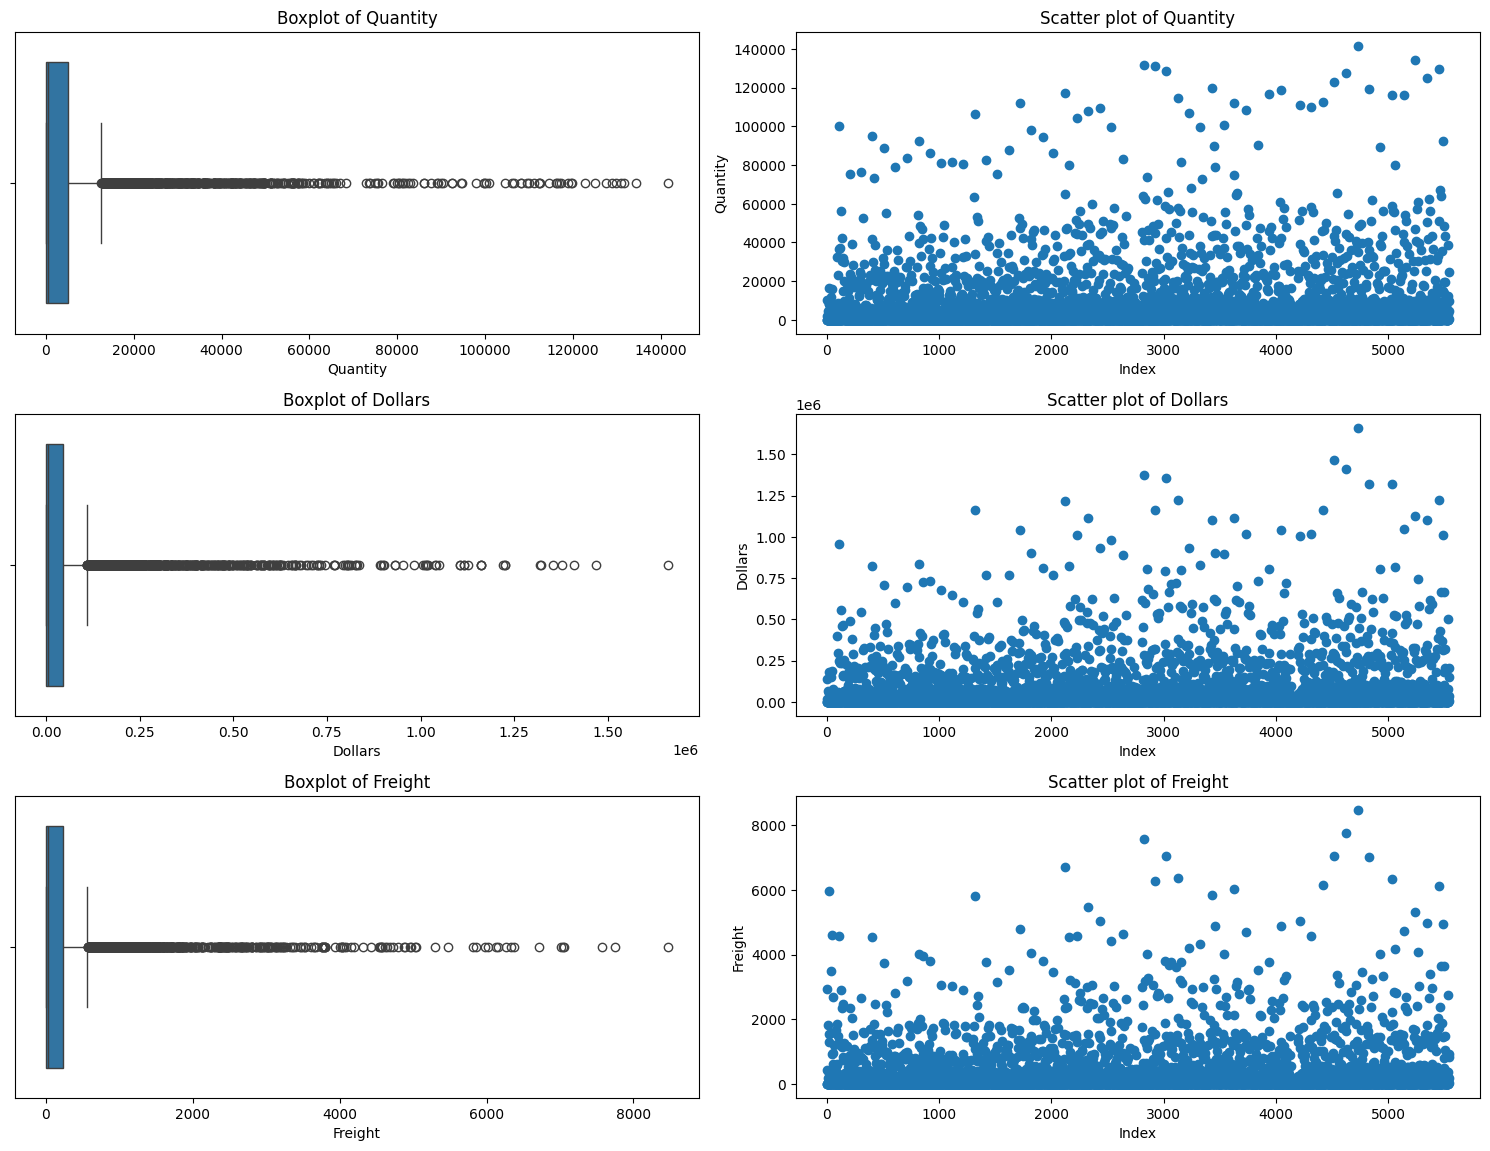

In [ ]:
visualize_outliers(invPurchase_df, columns_purinv)

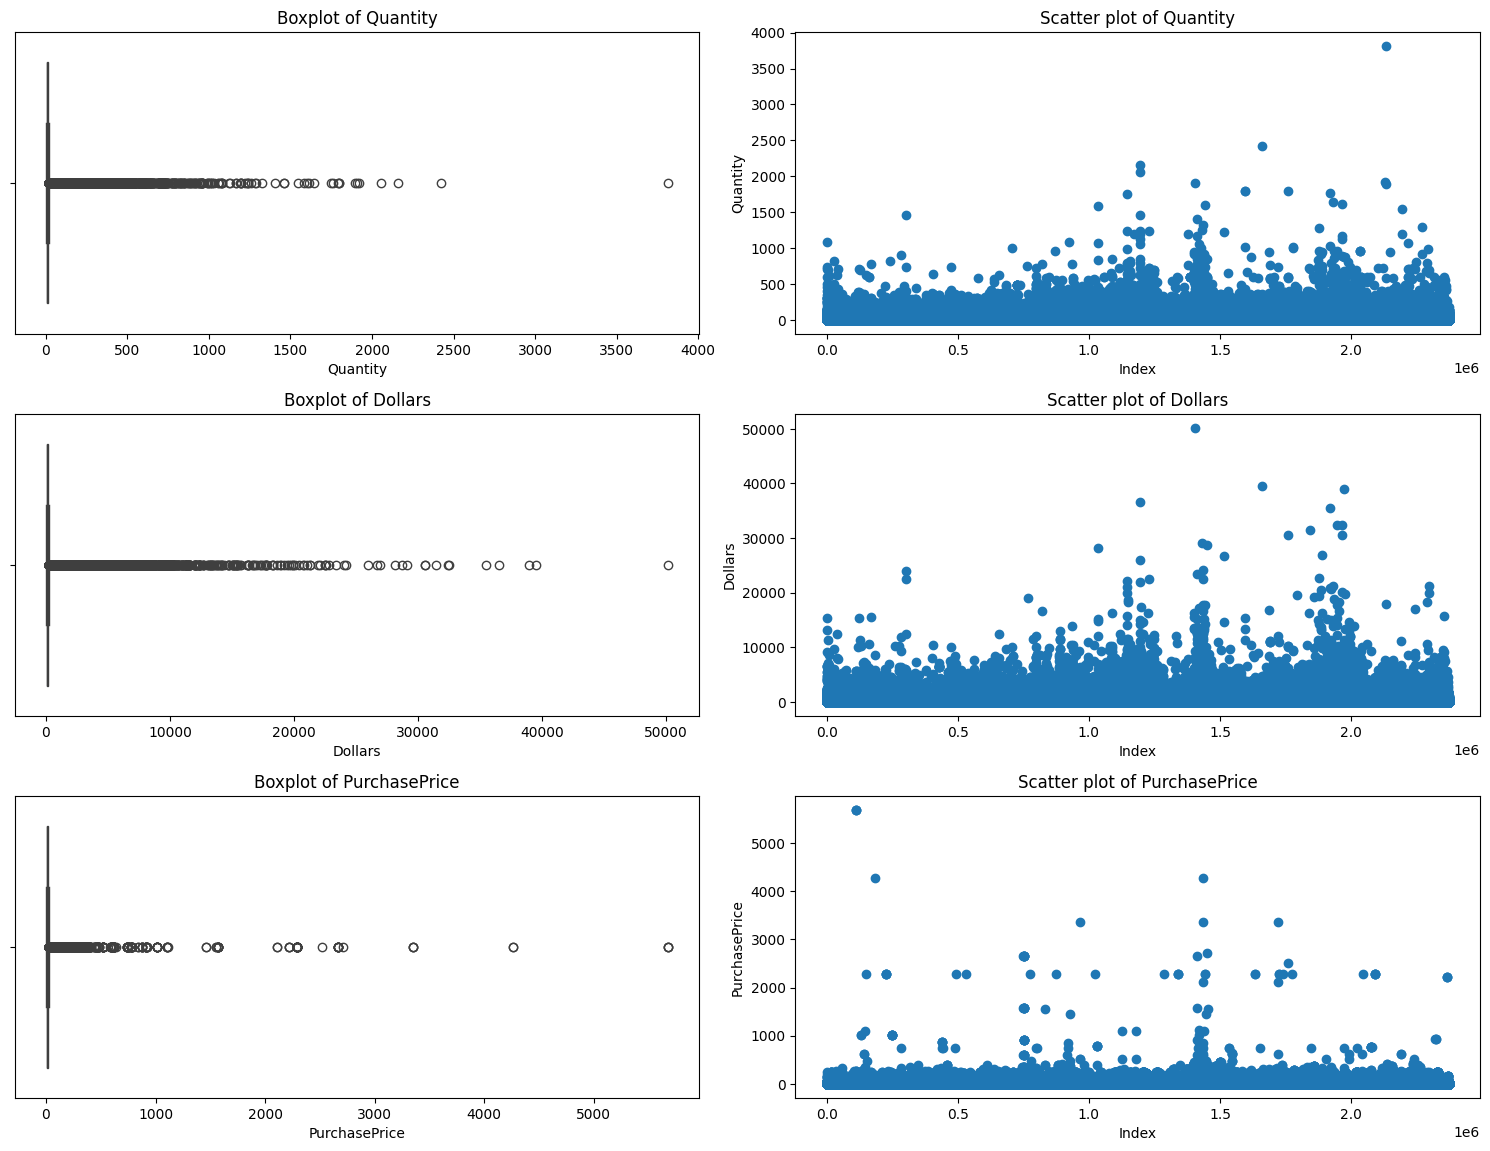

In [ ]:
visualize_outliers(purchase_df, columns_pur)

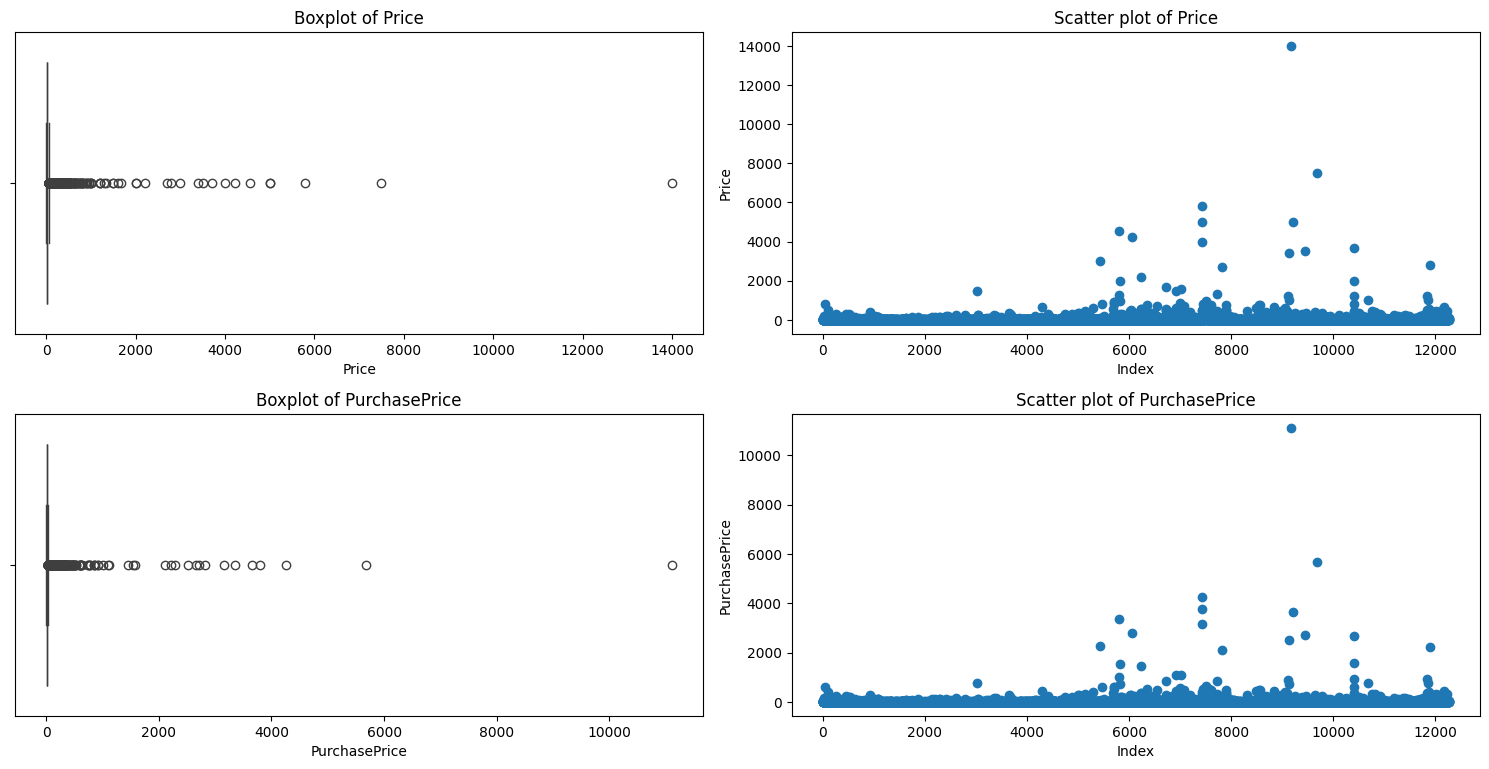

In [ ]:
visualize_outliers(purchasePrice_df, columns_pprice)

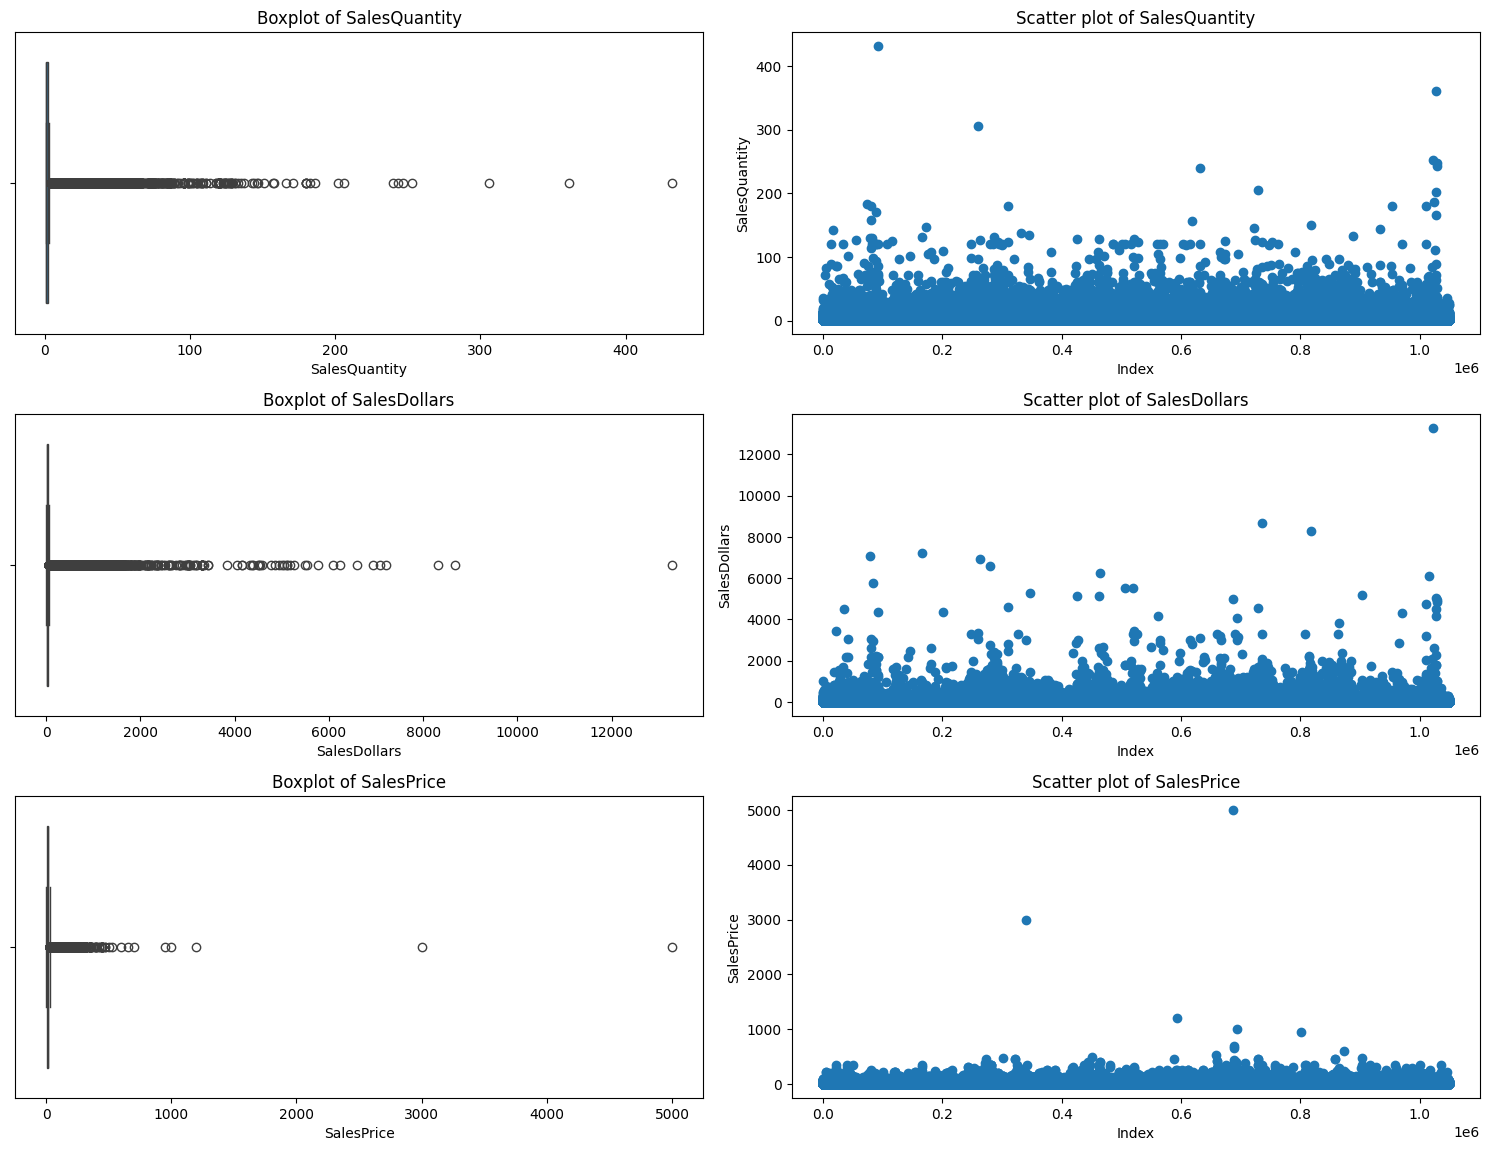

In [ ]:
visualize_outliers(sales_df, columns_sales)

***Save file***

In [ ]:
dataframes = {
    'beginInv_df': beginInv_df,
    'endInv_df': endInv_df,
    'purchase_df': purchase_df,
    'invPurchase_df': invPurchase_df,
    'purchasePrice_df': purchasePrice_df,
    'sales_df': sales_df
}


for name, df in dataframes.items():
    df.to_csv(f'{name}.csv', index=False)

#**Sales Forecasting with SARIMAX Model**

In [ ]:
sales_quantity_price = sales_df.groupby("SalesDate").agg({"SalesQuantity": "sum"})

In [ ]:

mod = SARIMAX(sales_quantity_price, order=(5, 1, 1), type="c")
res = mod.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['type']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
for i in pd.date_range("2016-03-01", "2016-03-31", freq="D"):
    sales_quantity_price.loc[i, "SalesQuantity"] = None
sales_quantity_price["forecast"] = res.predict(1, 90)

In [ ]:
sales_quantity_price_plot = sales_quantity_price.loc[:'2016-03-15']


fig = px.line(sales_quantity_price_plot,
              x=sales_quantity_price_plot.index,
              y=["SalesQuantity", "forecast"],
              title="Sales Performance and Forecast Analysis (Through March 15, 2016)",
              labels={"value": "Sales & Forecast", "index": "Date"},
              color_discrete_map={"SalesQuantity": "#636EFA", "forecast": "#EF553B"})


fig.update_layout(
    title={
        'text': "Sales Performance and Forecast Analysis (Through March 15, 2016)",
        'y': 0.92,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20, 'family': 'Arial', 'color': '#2a3f5f'}  # Giảm kích thước tiêu đề
    },
    xaxis_title="Date",
    yaxis_title="Sales & Forecast",
    xaxis=dict(
        tickmode='array',
        tickvals=sales_quantity_price_plot.index[::5],
        tickangle=-45,
        title_font=dict(size=16),
        tickfont=dict(size=10),
        showgrid=True,
        gridcolor='LightGray'
    ),
    yaxis=dict(
        title_font=dict(size=16),
        tickfont=dict(size=10),
        showgrid=True,
        gridcolor='LightGray'
    ),
    legend=dict(
        title="Variable",
        orientation="v",
        yanchor="middle",
        y=0.5,
        xanchor="left",
        x=1.02,
        font=dict(size=12)
    ),
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="black"
    ),
    hovermode="x unified",
    template="plotly_white",
    margin=dict(l=40, r=40, t=80, b=60),
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0)'
)


fig.show()


model_params = pd.DataFrame({
    'Parameter': ['Order (p, d, q)', 'AIC', 'BIC'],
    'Value': [(5, 1, 1), res.aic, res.bic]
})
print("\nModel Parameters:\n", model_params)





Model Parameters:
          Parameter      Value
0  Order (p, d, q)  (5, 1, 1)
1              AIC    1356.31
2              BIC    1370.85


In [ ]:

start_date = "2016-02-15"
end_date = "2016-02-29"


actual_values = sales_quantity_price.loc[start_date:end_date, 'SalesQuantity']


forecast_values = res.predict(start=start_date, end=end_date)


comparison_table = pd.DataFrame({
    'Date': actual_values.index,
    'Actual Sales': actual_values.values,
    'Forecasted Sales': forecast_values.values
}).set_index('Date')

print("\nActual vs Forecasted Sales (15/02/2016 - 29/02/2016):\n", comparison_table)



Actual vs Forecasted Sales (15/02/2016 - 29/02/2016):
             Actual Sales  Forecasted Sales
Date                                      
2016-02-15       6387.00           5517.70
2016-02-16       5588.00           7184.07
2016-02-17       7685.00           6232.32
2016-02-18       9055.00          10576.09
2016-02-19      14438.00          11700.75
2016-02-20      12450.00          13155.03
2016-02-21       6470.00          10044.51
2016-02-22       6317.00           4698.02
2016-02-23       7549.00           7503.45
2016-02-24       5743.00           7889.28
2016-02-25       7777.00           7711.75
2016-02-26      13416.00          10274.58
2016-02-27      13011.00          12491.24
2016-02-28       6866.00          10120.21
2016-02-29       5905.00           5909.19


In [ ]:

absolute_diff = abs(sales_quantity_price["SalesQuantity"] - sales_quantity_price["forecast"])
relative_diff = absolute_diff / sales_quantity_price["SalesQuantity"] * 100
print("\nMAPE:", relative_diff.dropna().mean())


mean_actual = sales_quantity_price["SalesQuantity"].mean()
sst = ((sales_quantity_price["SalesQuantity"] - mean_actual) ** 2).sum()
ssr = ((sales_quantity_price["SalesQuantity"] - sales_quantity_price["forecast"]) ** 2).sum()
r2 = 1 - (ssr / sst)
print(f'R²: {r2}')

mse = ((sales_quantity_price["SalesQuantity"] - sales_quantity_price["forecast"]) ** 2).mean()
print(f'MSE: {mse}')


rmse = mse ** 0.5
print(f'RMSE: {rmse}')



MAPE: 59.16774438622555
R²: 0.6958413424597891
MSE: 450192632.87068784
RMSE: 21217.743350099412


In [ ]:

print(relative_diff.sort_values(ascending=False).head(3))
print("March Forecast Total Demand: ", sales_quantity_price.loc["2016-03-01":"2016-03-31", "forecast"].sum())

SalesDate
2016-02-01   837.82
2016-02-04   737.13
2016-02-05   264.26
dtype: float64
March Forecast Total Demand:  254853.52898825431


#**Sale Forcasting with Prophet**

In [ ]:
print(sales_df)

                 InventoryId  Store  Brand                 Description  Size  \
0        1_HARDERSFIELD_1004      1   1004  Jim Beam w/2 Rocks Glasses  0.75   
1        1_HARDERSFIELD_1004      1   1004  Jim Beam w/2 Rocks Glasses  0.75   
2        1_HARDERSFIELD_1004      1   1004  Jim Beam w/2 Rocks Glasses  0.75   
3        1_HARDERSFIELD_1004      1   1004  Jim Beam w/2 Rocks Glasses  0.75   
4        1_HARDERSFIELD_1005      1   1005     Maker's Mark Combo Pack  0.75   
...                      ...    ...    ...                         ...   ...   
1048570  19_WINTERVALE_39384     19  39384    F Coppola Diamond Pnt Nr  0.75   
1048571  19_WINTERVALE_39384     19  39384    F Coppola Diamond Pnt Nr  0.75   
1048572  19_WINTERVALE_39384     19  39384    F Coppola Diamond Pnt Nr  0.75   
1048573  19_WINTERVALE_39384     19  39384    F Coppola Diamond Pnt Nr  0.75   
1048574  19_WINTERVALE_39384     19  39384    F Coppola Diamond Pnt Nr  0.75   

         SalesQuantity  SalesDollars  S

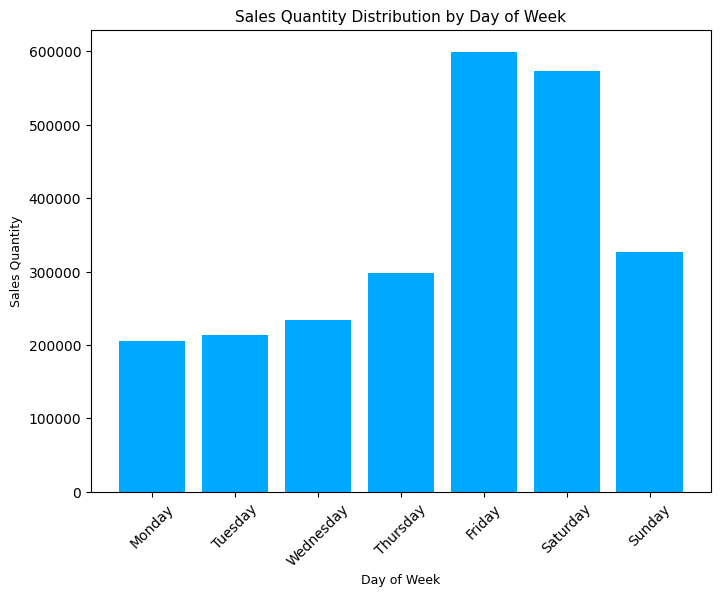

In [ ]:
sales_df['DayOfWeek'] = sales_df['SalesDate'].dt.dayofweek


sales_by_dayofweek = sales_df.groupby('DayOfWeek').agg({'SalesQuantity': 'sum'}).reset_index()


day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_by_dayofweek['DayName'] = sales_by_dayofweek['DayOfWeek'].apply(lambda x: day_names[x])


plt.figure(figsize=(8,6))
plt.bar(sales_by_dayofweek['DayName'], sales_by_dayofweek['SalesQuantity'], color='#00A9FF')
plt.title('Sales Quantity Distribution by Day of Week', fontsize=11)
plt.xlabel('Day of Week', fontsize=9)
plt.ylabel('Sales Quantity', fontsize=9)
plt.xticks(rotation=45)
plt.show()


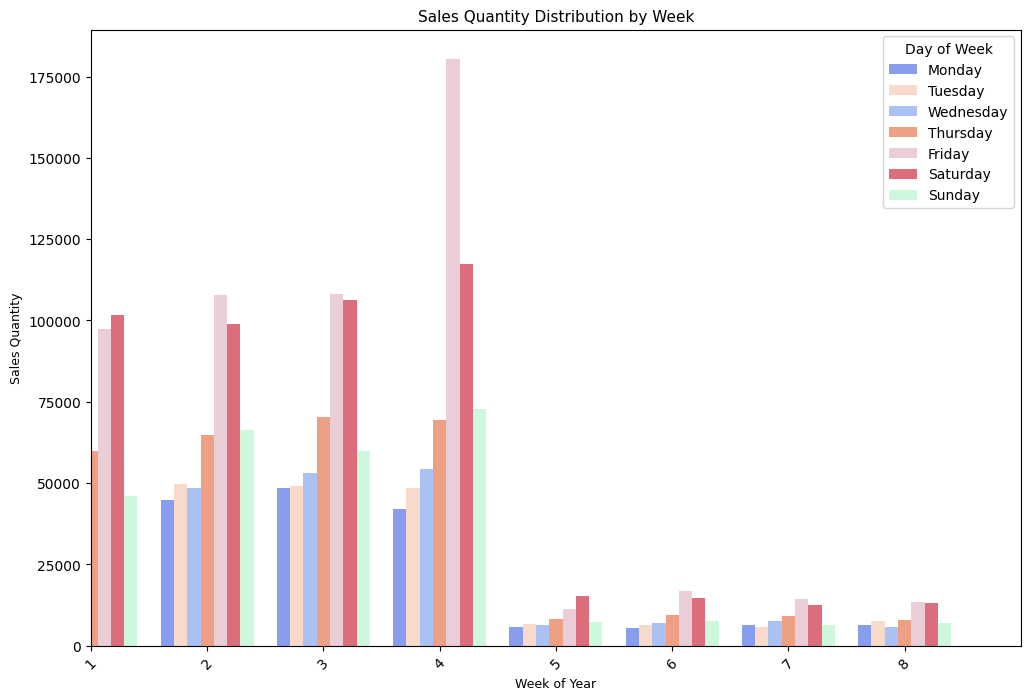

In [ ]:
custom_palette={
    'Monday': '#7695FF',
    'Tuesday': '#FFD7C4',
    'Wednesday': '#9DBDFF',
    'Thursday': '#FF9874',
    'Friday': '#EECAD5',
    'Saturday': '#EF5A6F',
    'Sunday': '#C7FFD8'

}
sales_df['Week']=sales_df['SalesDate'].dt.isocalendar().week
sales_df['DayOfWeek']=sales_df['SalesDate'].dt.dayofweek
sales_grouped=sales_df[(sales_df['Week']<=8)].groupby(['Week','DayOfWeek']).agg({'SalesQuantity':'sum'}).reset_index()

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_grouped['DayName']=sales_grouped['DayOfWeek'].apply(lambda x : day_names[x])

plt.figure(figsize=(12,8))

sns.barplot(data=sales_grouped,x='Week',y="SalesQuantity",hue="DayName",palette=custom_palette)

plt.title('Sales Quantity Distribution by Week', fontsize=11)
plt.xlabel('Week of Year', fontsize=9)
plt.ylabel('Sales Quantity', fontsize=9)
plt.xticks(rotation=45)

plt.xlim(0, 8)

plt.legend(title='Day of Week', loc='upper right')
plt.show()



In [ ]:
sales_df['SalesDate']=pd.to_datetime(sales_df['SalesDate'])
quantity_df=sales_df.groupby('SalesDate').agg({'SalesQuantity':'sum'}).reset_index()
print(quantity_df)

    SalesDate  SalesQuantity
0  2016-01-01          49911
1  2016-01-02          93114
2  2016-01-03          53037
3  2016-01-04          41341
4  2016-01-05          40831
5  2016-01-06          51358
6  2016-01-07          59792
7  2016-01-08          97389
8  2016-01-09         101690
9  2016-01-10          46146
10 2016-01-11          44654
11 2016-01-12          49803
12 2016-01-13          48556
13 2016-01-14          64830
14 2016-01-15         107858
15 2016-01-16          98860
16 2016-01-17          66170
17 2016-01-18          48512
18 2016-01-19          49128
19 2016-01-20          53132
20 2016-01-21          70333
21 2016-01-22         107974
22 2016-01-23         106146
23 2016-01-24          59926
24 2016-01-25          41917
25 2016-01-26          48505
26 2016-01-27          54176
27 2016-01-28          69222
28 2016-01-29         180426
29 2016-01-30         117456
30 2016-01-31          72766
31 2016-02-01           5771
32 2016-02-02           6529
33 2016-02-03 

In [ ]:
forecast_start_dt= date(2016,2,15 )
forecast_start_date = (forecast_start_dt).strftime("%Y-%m-%d")
print(forecast_start_date)

prediction_days = 30

2016-02-15


In [ ]:
quantity_df_copy = quantity_df.copy()
quantity_df_copy = quantity_df_copy.rename(columns={'SalesDate': 'ds', 'SalesQuantity': 'y'})


quantity_df_copy['y'] = pd.to_numeric(quantity_df_copy['y'], errors='coerce')
quantity_df_copy['ds'] = pd.to_datetime(quantity_df_copy['ds'])


quantity_df_copy = quantity_df_copy[quantity_df_copy['y'] < quantity_df_copy['y'].quantile(0.8)]


quantity_df_copy['y'] = np.log(quantity_df_copy['y'] + 1)


train_set = quantity_df_copy[quantity_df_copy['ds'] < forecast_start_date]


m = Prophet(changepoint_prior_scale=0.3, seasonality_prior_scale=10, weekly_seasonality=True)
m.fit(train_set)


future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)


filter = fcst_prophet_train['ds'] >= forecast_start_date
predicted_df = fcst_prophet_train[filter][['ds', 'yhat']]

predicted_df['yhat'] = np.exp(predicted_df['yhat']) - 1
predicted_df['yhat'] = predicted_df['yhat'].round().astype(int)  # Làm tròn và chuyển thành số nguyên

print(predicted_df)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8gix0ugi/dmvvc15a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8gix0ugi/mrwkim08.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47448', 'data', 'file=/tmp/tmp8gix0ugi/dmvvc15a.json', 'init=/tmp/tmp8gix0ugi/mrwkim08.json', 'output', 'file=/tmp/tmp8gix0ugi/prophet_modelr_ngmkbh/prophet_model-20241028061439.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:14:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:14:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


           ds   yhat
33 2016-02-15   5457
34 2016-02-16   6442
35 2016-02-17   6827
36 2016-02-18   9592
37 2016-02-19  16789
38 2016-02-20  14843
39 2016-02-21   7450
40 2016-02-22   5489
41 2016-02-23   6480
42 2016-02-24   6868
43 2016-02-25   9649
44 2016-02-26  16889
45 2016-02-27  14931
46 2016-02-28   7494
47 2016-02-29   5522
48 2016-03-01   6519
49 2016-03-02   6909
50 2016-03-03   9707
51 2016-03-04  16990
52 2016-03-05  15020
53 2016-03-06   7539
54 2016-03-07   5555
55 2016-03-08   6558
56 2016-03-09   6950
57 2016-03-10   9765
58 2016-03-11  17091
59 2016-03-12  15110
60 2016-03-13   7583
61 2016-03-14   5588
62 2016-03-15   6597


In [ ]:
quantity_df_copy=quantity_df.copy()
quantity_df_copy.columns=['ds','ytrue']
predicted_df=predicted_df.merge(quantity_df_copy)

In [ ]:
predicted_df

,ds,yhat,ytrue
0,2016-02-15,5457,6387
1,2016-02-16,6442,5588
2,2016-02-17,6827,7685
3,2016-02-18,9592,9055
4,2016-02-19,16789,14438
5,2016-02-20,14843,12450
6,2016-02-21,7450,6470
7,2016-02-22,5489,6317
8,2016-02-23,6480,7549
9,2016-02-24,6868,5743


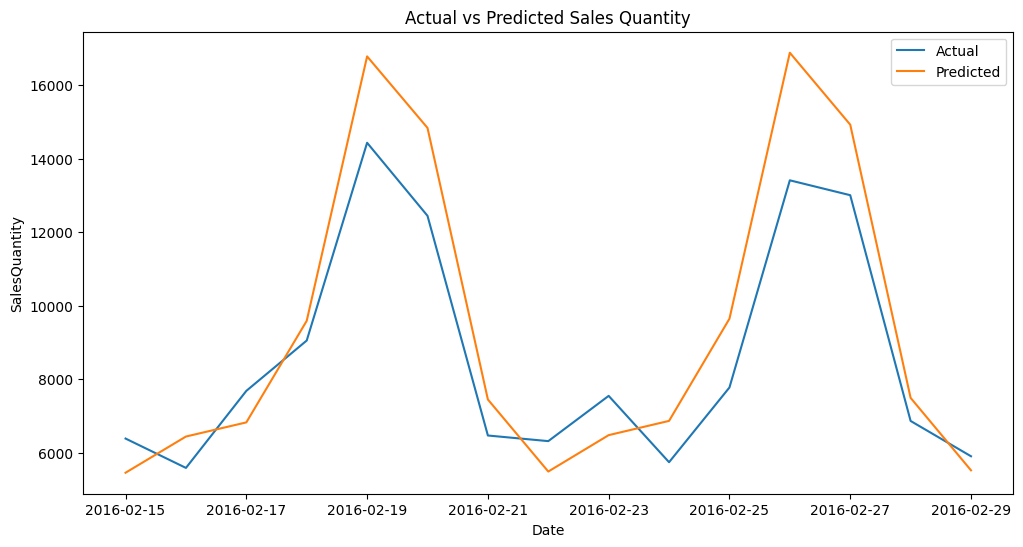

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(predicted_df['ds'],predicted_df['ytrue'],label="Actual")
plt.plot(predicted_df['ds'],predicted_df['yhat'],label="Predicted")
plt.title("Actual vs Predicted Sales Quantity")
plt.xlabel("Date")
plt.ylabel("SalesQuantity")
plt.legend()
plt.show()

Calculate Mape

In [ ]:
def mape(actual, pred):
    '''
    Mean Absolute Percentage Error (MAPE) Function

    input: list/series for actual values and predicted values
    output: mape value
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
mape(predicted_df['ytrue'], predicted_df['yhat'])

14.986292051288796

Cross Validation

In [ ]:
m = Prophet()
m.fit(train_set)
df_cv = cross_validation(m, initial='30 days', period='7 days', horizon='7 days')


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8gix0ugi/kklyi_o5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8gix0ugi/snw_t09p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25153', 'data', 'file=/tmp/tmp8gix0ugi/kklyi_o5.json', 'init=/tmp/tmp8gix0ugi/snw_t09p.json', 'output', 'file=/tmp/tmp8gix0ugi/prophet_modelek6v1sqi/prophet_model-20241028061446.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:14:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:14:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cu

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 14.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8gix0ugi/upso921b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8gix0ugi/1fq3b2p2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72957', 'data', 'file=/tmp/tmp8gix0ugi/upso921b.json', 'init=/tmp/tmp8gix0ugi/1fq3b2p2.json', 'output', 'file=/tmp/tmp8gix0ugi/prophet_model35atmrhg/prophet_model-20241028061446.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:14:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:14:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8gix0ugi/epb54ayl.json
DEBUG:cmdstanpy:input tempfi

In [ ]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,2.23,1.49,1.32,0.15,0.15,0.14,0.00
1,2 days,2.24,1.50,1.38,0.16,0.16,0.15,0.00
2,3 days,2.54,1.59,1.49,0.17,0.17,0.16,0.00
3,4 days,2.93,1.71,1.67,0.18,0.18,0.18,0.00
4,5 days,2.95,1.72,1.71,0.18,0.18,0.18,0.00
5,6 days,157.13,12.54,9.45,0.98,0.98,1.07,0.00
6,7 days,3.19,1.79,1.78,0.20,0.20,0.20,0.00


# **ABC Analysis**

In [ ]:
ABC = (
    sales.groupby("Brand").agg({"SalesQuantity":"sum"}).sort_values("SalesQuantity",ascending=False)
)
display("Top 5 Demand",ABC.head(),
        "Bottom 5 Demand", ABC.tail(),
        "describe data", ABC.describe().T,
        )
bins =[0,100,1000,30000]
labels= ["C:<100","B:100-1k","A:1k-30k"]
ABC['bin']= pd.cut(ABC["SalesQuantity"], bins, labels=labels)

'Top 5 Demand'

,SalesQuantity
Brand,
8111,28544
1892,23121
4261,20226
3606,19200
5111,18411


'Bottom 5 Demand'

,SalesQuantity
Brand,
17576,1
4308,1
4260,1
4164,1
5114,1


'describe data'

,count,mean,std,min,25%,50%,75%,max
SalesQuantity,7658.00,320.08,1015.02,1.00,10.00,49.00,238.00,28544.00


Text(0, 0.5, 'Total Brand')

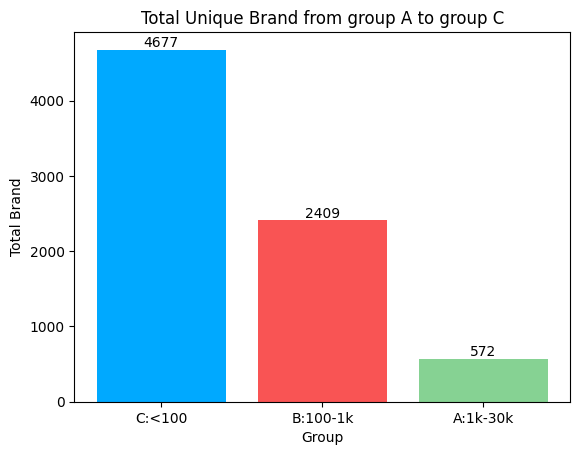

In [ ]:
plt.bar(ABC['bin'].value_counts().index, ABC['bin'].value_counts().values, color=['#00A9FF','#F95454','#86D293'])
for i, value in enumerate(ABC['bin'].value_counts().values):
  plt.text (i, value, str(value), ha='center', va='bottom')
plt.title("Total Unique Brand from group A to group C")
plt.xlabel("Group")
plt.ylabel("Total Brand")


In [ ]:
total_group = ABC.groupby('bin').agg({"SalesQuantity":'sum'})['SalesQuantity']
total= px.histogram(total_group.value_counts(), x = total_group.index, y = total_group.values, color = total_group.index,
                    title ="Total Sales Quantity of brand from group A to group C", text_auto =True )
total.update_layout(
    width=800,
    height=600,
    xaxis_title_text="Group",
    yaxis_title_text="Total Sales Quantity",
)
total.show()


<ipython-input-78-36b221e430a2>:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



# **Purchase Analysis**

## **EQQ Analysis**

In [ ]:
# * Demand 2 month


demand_jan_feb = (

    sales.groupby("Brand")

    .agg({"SalesQuantity": "sum"})

    .sort_values("SalesQuantity", ascending=False)
)


# * Cost Per Order (CPO), Freight Cost

purchase_invoice = pd.merge(
    left=purchase[["PONumber", "Brand", "Description", "Size", "Quantity"]],
    right=invPurchase,
    on="PONumber",
    how="right",
)

purchase_invoice_vol = pd.merge(
    left=purchase_invoice,
    right=purchasePrice[["Brand", "Volume"]],
    on="Brand",
    how="left",
)
purchase_invoice_vol["vol_quantity"] = purchase_invoice_vol["Quantity_x"].astype(
    "float"
) * purchase_invoice_vol["Volume"].astype("float")
purchase_invoice_vol.set_index("PONumber", inplace=True)
purchase_invoice_vol["vol_quantity_total"] = purchase_invoice_vol.groupby(
    "PONumber"
).agg({"vol_quantity": "sum"})
purchase_invoice_vol["CPO"] = (
    purchase_invoice_vol["vol_quantity"]
    / purchase_invoice_vol["vol_quantity_total"]
    * purchase_invoice_vol["Freight"]
)

CPO = purchase_invoice_vol.groupby("Brand").agg({"CPO": "mean"})

# * Cost Per Unit (C), Holding Cost (%) assume holding cost = 30%, Holding Cost ($) = I*C = I*0.3
C = purchasePrice[["Brand", "PurchasePrice"]].set_index("Brand")
H = C * 0.3

# * Combine to Brand
EOQ = demand_jan_feb.copy()
EOQ["CPO"] = CPO
EOQ["H"] = H

In [ ]:
# * Calculate and dropna
EOQ["EOQ"] = 2 * EOQ["SalesQuantity"] * EOQ["CPO"] / EOQ["H"]
EOQ["EOQ"] = EOQ["EOQ"].apply(lambda x: ceil(pow(x, 0.5)) if pd.notna(x) else 0)
EOQ.dropna(inplace=True)
EOQ["Volume"] = purchasePrice[["Brand", "Volume"]].set_index("Brand")
EOQ['ABC']=ABC['bin']
display(EOQ.head(15), EOQ.describe(),EOQ.groupby("ABC").agg({"EOQ":"mean"}).T)

NameError: name 'ABC' is not defined

## **Lead time Analysis**


In [ ]:
print(purchase_df)

                  InventoryId  Store  Brand                   Description  \
0           69_MOUNTMEND_8412     69   8412     Tequila Ocho Plata Fresno   
1            30_CULCHETH_5255     30   5255  TGI Fridays Ultimte Mudslide   
2           34_PITMERDEN_5215     34   5215  TGI Fridays Long Island Iced   
3         1_HARDERSFIELD_5255      1   5255  TGI Fridays Ultimte Mudslide   
4           76_DONCASTER_2034     76   2034     Glendalough Double Barrel   
...                       ...    ...    ...                           ...   
2372469     49_GARIGILL_22298     49  22298       Zorvino Vyds Sangiovese   
2372470  1_HARDERSFIELD_19556      1  19556    Zorvino Bacca Z Blackberry   
2372471   66_EANVERNESS_22297     66  22297            Zorvino Vyds Pearz   
2372472    69_MOUNTMEND_19557     69  19557  Zorvino Fragole Z Strawberry   
2372473    55_DRY GULCH_22298     55  22298       Zorvino Vyds Sangiovese   

         Size  VendorNumber                  VendorName  PONumber     PODat

In [ ]:
purchase_df["lead_time"] = (
    pd.to_datetime(purchase_df["ReceivingDate"]) - pd.to_datetime(purchase_df["PODate"])
).dt.days

lead_time_brand = purchase_df.groupby(['Brand', 'Description']).agg(
    Max_LT_inDays=('lead_time', 'max'),
    Min_LT_inDays=('lead_time', 'min'),
    Avg_LT_inDays=('lead_time', 'mean')).round(2).reset_index()


In [ ]:
display(lead_time_brand.T, lead_time_brand.describe().T)

,0,1,2,3,4,5,6,7,8,9,...,10654,10655,10656,10657,10658,10659,10660,10661,10662,10663
Brand,58,60,61,62,63,70,72,75,77,79,...,90080,90085,90086,90087,90088,90089,90090,90604,90609,90631
Description,Gekkeikan Black & Gold Sake,Canadian Club 1858 VAP,Margaritaville Silver,Herradura Silver Tequila,Herradura Reposado Tequila,Luxardo Amaretto di Saschira,No. 3 London Dry Gin,Three Olives Tomato Vodka,Three Olives Espresso Vodka,Three Olives Loopy Vodka,...,Ch Cantenac Brown Margaux 11,Ch Lilian 09 Ladouys St Este,La Dame Montrose St Estep 11,Ch Mouton Rothschild 12 Paui,Ch Le Petite Mouton 12 Pauil,Ch Lynch Bages 12 Pauillac,Ch Lafite Rothschild 12,Ch Lynch Bages Pauilac,Flavor Essence Variety 5 Pak,Luxardo Maraschino Cherries
Max_LT_inDays,14,13,12,12,12,8,12,7,13,13,...,12,9,9,7,4,12,5,9,13,14
Min_LT_inDays,3,4,3,3,3,6,3,7,3,3,...,12,7,9,3,3,4,4,3,10,5
Avg_LT_inDays,7.76,7.66,8.12,7.33,7.32,7.33,8.64,7.00,7.29,7.27,...,12.00,8.00,9.00,4.80,3.50,7.33,4.50,7.38,10.36,9.21


,count,mean,std,min,25%,50%,75%,max
Brand,10664.00,18045.89,12642.58,58.00,5813.75,18770.50,25517.50,90631.00
Max_LT_inDays,10664.00,11.05,2.26,3.00,10.00,12.00,13.00,14.00
Min_LT_inDays,10664.00,4.85,2.26,3.00,3.00,4.00,6.00,14.00
Avg_LT_inDays,10664.00,7.82,1.22,3.00,7.28,7.71,8.29,14.00


In [ ]:
fig = px.histogram(lead_time_brand, x='Avg_LT_inDays', nbins=50, title="Distribution of Average Lead Time", text_auto=True)

fig.update_layout(
    bargap=0.1,
    xaxis_title_text="Average Lead Times (Days)",  # xaxis label
    yaxis_title_text="Frequency",  # yaxis label
    height=600,
)
fig.update_traces(marker_color='#00A9FF')

fig.show()

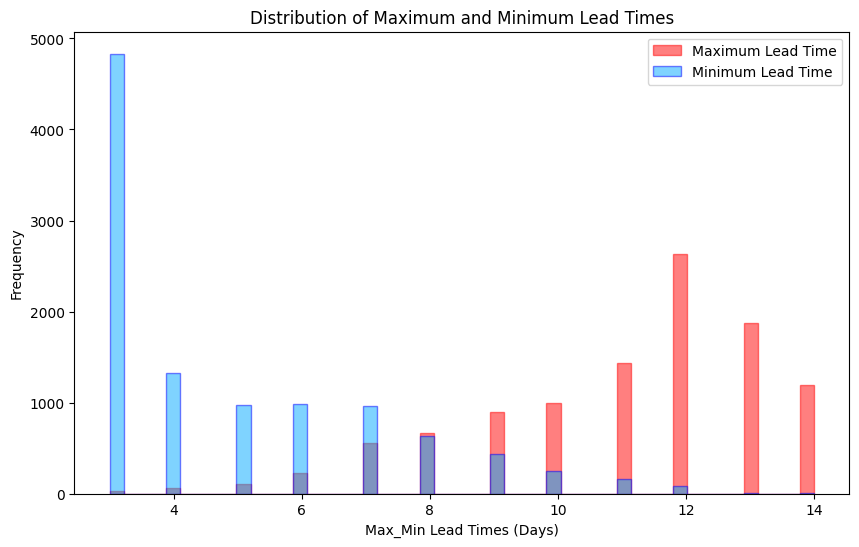

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

#histogram for Max Lead Time
ax.hist(lead_time_brand["Max_LT_inDays"], bins=50, density=False, edgecolor="red", alpha=0.5, label="Maximum Lead Time", color='red')

# histogram for Min Lead Time
ax.hist(lead_time_brand["Min_LT_inDays"], bins=50, density=False, edgecolor="blue", alpha=0.5, label="Minimum Lead Time", color='#00A9FF')

ax.set_xlabel("Max_Min Lead Times (Days)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Maximum and Minimum Lead Times")

ax.legend()

plt.show()


## **Safety Stock**


In [ ]:
# * Average Daily Unit Sales
sales_summary = sales_df.groupby(['Brand', 'Description']).agg(
                        Max_Sales_Qty=("SalesQuantity", 'max'),
                        Min_Sales_Qty=("SalesQuantity", 'min'),
                        Tot_SalesQty=('SalesQuantity', 'sum')).reset_index()
total_sales_days = (sales_df['SalesDate'].max() - sales_df['SalesDate'].min()).days
sales_summary['Avg_Daily_SalesQty'] = (sales_summary['Tot_SalesQty'] / total_sales_days).round(2)
max_sales = sales_summary.groupby(['Brand', 'Description']).agg(
    Max_Daily_Sales=('Max_Sales_Qty', 'max')).reset_index()
sales_summary = pd.merge(sales_summary, max_sales, on=['Brand', 'Description'], how='left')

In [ ]:
#merge the lead time and sales data-->Safety stock data
safetystock_data = pd.merge(sales_summary, lead_time_brand, on = ["Brand", "Description"])

In [ ]:
# Calculate optimal safety stock and round up to the nearest whole number
safetystock_data["Optimal_SS"] = np.ceil(
    (safetystock_data["Max_LT_inDays"] - safetystock_data["Avg_LT_inDays"]) *
    safetystock_data['Avg_Daily_SalesQty']
).round(0)

# Calculate maximum safety stock and round up to the nearest whole number
# safetystock_data["Max_SS"] = np.ceil(
#     (safetystock_data["Max_Daily_Sales"] * safetystock_data["Max_LT_inDays"]) -
#     (safetystock_data["Avg_Daily_SalesQty"] * safetystock_data["Avg_LT_inDays"])
# ).round(0)

In [ ]:
# Select relevant columns for the safety stock summary
safetystock_summary = safetystock_data[["Brand", "Description", "Max_Sales_Qty", "Tot_SalesQty", "Avg_Daily_SalesQty", "Max_Daily_Sales",
                           "Max_LT_inDays", "Avg_LT_inDays", "Optimal_SS"]]

# Print a random sample of 5 rows from the safety stock summary
print("Safety stock summary (random sample):\n", safetystock_summary.sample(5, random_state=random.seed()))

Safety stock summary (random sample):
       Brand                   Description  Max_Sales_Qty  Tot_SalesQty  \
1711   4723            Kinky Flame Whisky             58           801   
3921  18651     Alexana Pnt Nr Willamette              1             2   
5011  23353  Parducci True Grit 11 Cab Sv             14           653   
1579   4278  Capt Morgan Parrot Bay Cocnt             12           434   
2617   8671  Appleton Est VX Jamaican Rum              8           232   

      Avg_Daily_SalesQty  Max_Daily_Sales  Max_LT_inDays  Avg_LT_inDays  \
1711               13.58               58              9           8.71   
3921                0.03                1              9           8.00   
5011               11.07               14             11           9.29   
1579                7.36               12             14           7.63   
2617                3.93                8             12           7.67   

      Optimal_SS  
1711        4.00  
3921        1.00  
5011    

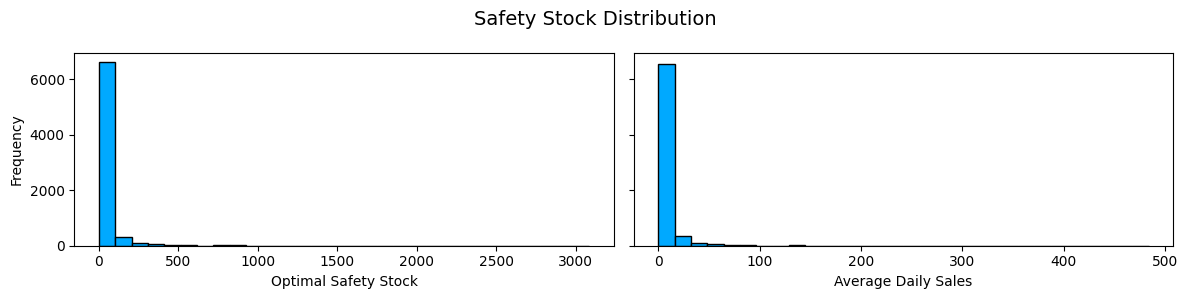

In [ ]:
# Create a figure with two subplots to compare optimal safety stock and average daily sales
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)
fig.suptitle("Safety Stock Distribution", color='black', fontsize=14)

# Plot histogram of optimal safety stock
axes[0].hist(safetystock_summary["Optimal_SS"], bins=30, density=False, color="#00A9FF",
             edgecolor='black', label="Optimal Safety Stock")
axes[0].set_xlabel("Optimal Safety Stock")
axes[0].set_ylabel("Frequency")

# Plot histogram of average daily sales
axes[1].hist(safetystock_summary["Avg_Daily_SalesQty"], bins=30, density=False,
             color="#00A9FF", edgecolor='black', label="Average Daily Sales")
axes[1].set_xlabel("Average Daily Sales")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

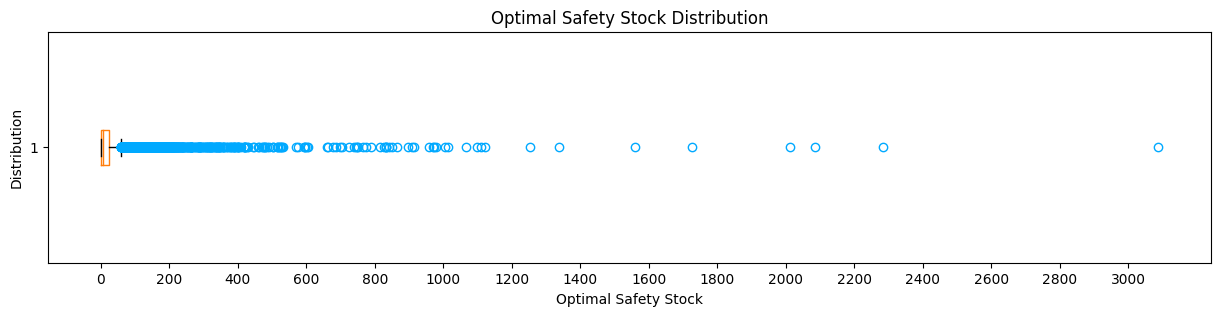

In [ ]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.boxplot(safetystock_summary['Optimal_SS'], vert=False, boxprops=dict(color='tab:orange'),
                            flierprops=dict(markeredgecolor='#00A9FF'))
ax.set_xticks(range(0, int(safetystock_summary["Optimal_SS"].max()) + 1, 200))
ax.set_title('Optimal Safety Stock Distribution')
ax.set_xlabel('Optimal Safety Stock')
ax.set_ylabel('Distribution')
plt.show()

Correlation between Total Sales, Average Lead Time and  Optimal Safety Stock

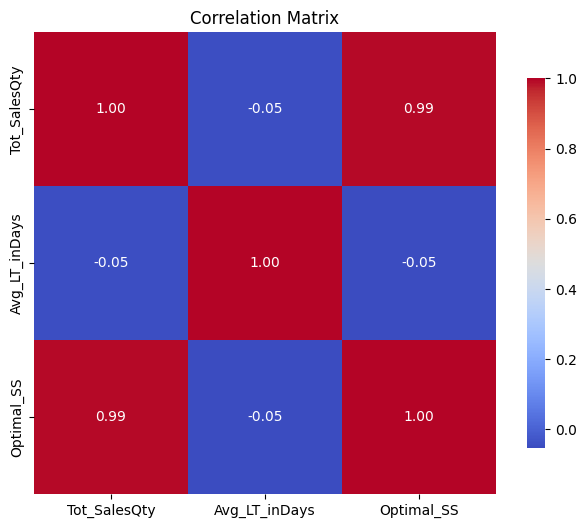

In [ ]:
correlation_data = safetystock_summary[['Tot_SalesQty', 'Avg_LT_inDays', 'Optimal_SS']]

correlation_matrix = correlation_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .8})
plt.title('Correlation Matrix')
plt.show()

Optimal Stock Level Calculation

In [ ]:
## Get the latest on-hand inventory for each brand
latest_onhand_inv = (endInv_df[endInv_df['endDate'] == endInv_df['endDate'].max()]
                     .groupby(['Brand', 'Description'])
                     .agg(Onhand_Stock=('onHand', 'sum'))
                     .reset_index())

In [ ]:
# Merging the current stock levels with the previously calculated data, filling NaN values with 0, and selecting specific columns.
onhand_inv_data = safetystock_data.merge(latest_onhand_inv, on=['Brand', 'Description'], how='left').fillna({'Onhand_Stock': 0})
onhand_inv_data = onhand_inv_data[["Brand", "Description", "Optimal_SS", "Onhand_Stock"]]

In [ ]:
#Determin Invetory status of each products, categorize them as  shortage or balance or surplus
onhand_inv_data['Inventory_Status'] = onhand_inv_data['Onhand_Stock'] - onhand_inv_data['Optimal_SS']

onhand_inv_data['Inv_Shortage/Surplus'] = np.where(onhand_inv_data['Inventory_Status'] < 0, 'Inv_Shortage',
                                                   np.where(onhand_inv_data['Inventory_Status'] == 0, 'Balance', 'Inv_Surplus'))

# Shorten onhand inventory data as inv_status for easier referencing
inv_status = onhand_inv_data.set_index('Brand')
# Print a random sample of 10 rows from the inv_status DataFrame
print("Random 10 rows from inv_status: \n", inv_status.sample(n=10, random_state=random.seed()))

Random 10 rows from inv_status: 
                         Description  Optimal_SS  Onhand_Stock  \
Brand                                                           
1395                       Old Crow       85.00       1056.00   
11164      Ame Neyers Cab Svgn Napa        1.00         32.00   
13561             Stump Jump Shiraz        0.00          1.00   
7902              Piehole Apple Pie        0.00          0.00   
24289  Thierry Delaunay Tour Svgn B        4.00       1039.00   
4703     Blue Chair Bay Coconut Rum       21.00         78.00   
2597                   Beefeater 24        3.00          0.00   
4198   Sailor Jerry Spiced Navy Rum      179.00       6347.00   
2676                  Grand MacNish       30.00       1076.00   
6356            Taylor Cream Sherry       56.00        727.00   

       Inventory_Status Inv_Shortage/Surplus  
Brand                                         
1395             971.00          Inv_Surplus  
11164             31.00          Inv_Surplus

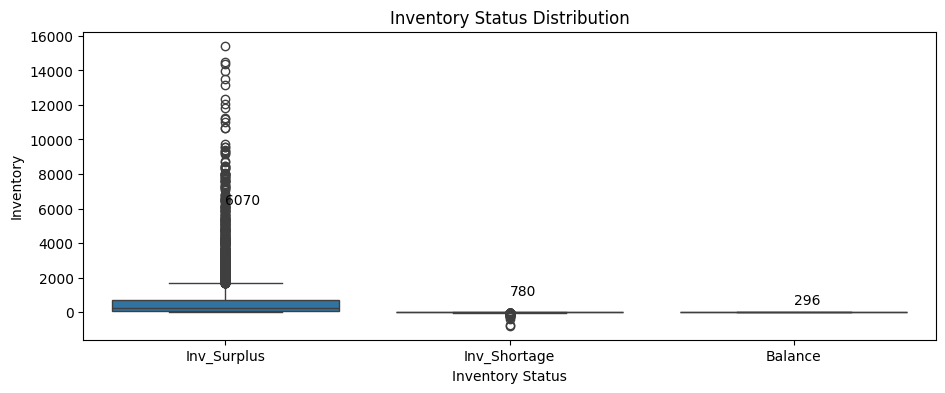

In [ ]:
#Inventory Status distribution
fig, ax = plt.subplots(figsize=(11, 4))
sns.boxplot(data=inv_status, x="Inv_Shortage/Surplus", y="Inventory_Status",  ax=ax)
plt.xlabel("Inventory Status")
plt.ylabel("Inventory")
plt.title("Inventory Status Distribution")

#print count on the plot
for i, count in enumerate(inv_status['Inv_Shortage/Surplus'].value_counts()):
    plt.text(i, count, str(count), ha='left', va='bottom')

plt.show()

## **Reorder Point Analysis**


<ipython-input-81-3231c2585652>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-81-3231c2585652>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Top 5 sản phẩm với RoP cao nhất:
                     Description  Max_Sales_Qty  Tot_SalesQty  \
Brand                                                          
1892                 Yukon Jack            127         23121   
3606   Smirnoff Raspberry Vodka             50         19200   
3609     Smirnoff Vanilla Vodka             58         10355   
8111          Smirnoff 80 Proof            127         28544   
4798     Sambuca Romana Liqueur             76          9059   

       Avg_Daily_SalesQty  Max_LT_inDays  Avg_LT_inDays  Optimal_SS    RoP  
Brand                                                                       
1892               391.88             13           7.68     2085.00 925.00  
3606               325.42             13           7.70     1725.00 781.00  
3609               175.51             12           7.72      752.00 603.00  
8111               483.80             14           7.62     3087.00 600.00  
4798               153.54             12           7.68

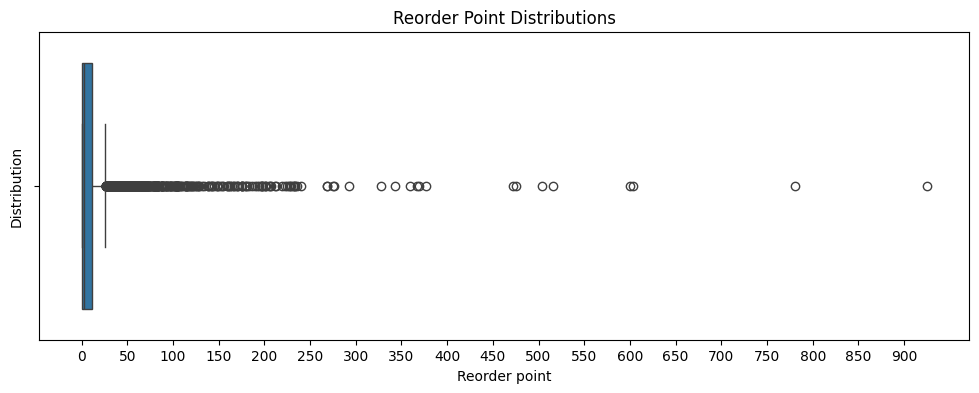

In [ ]:

safetystock_data["RoP"] = np.ceil((safetystock_data["Avg_Daily_SalesQty"] * safetystock_data["Avg_LT_inDays"]) - safetystock_data["Optimal_SS"])
safetystock_data["RoP"] = safetystock_data["RoP"].replace(-0, 0)

RoP_Summary = safetystock_data[["Brand", "Description", "Max_Sales_Qty", "Tot_SalesQty", "Avg_Daily_SalesQty",
                                "Max_LT_inDays", "Avg_LT_inDays", "Optimal_SS", "RoP"]].set_index('Brand')


RoP_max = RoP_Summary[RoP_Summary["RoP"] < 0]
RoP_max['RoP_max'] = np.ceil((RoP_max["Avg_Daily_SalesQty"] * RoP_max["Max_LT_inDays"]) - RoP_max["Optimal_SS"])
RoP_Summary.loc[RoP_Summary["RoP"] < 0, "RoP"] = RoP_max["RoP_max"]
RoP_max.drop(columns=["RoP_max"], inplace=True)


top_5_RoP = RoP_Summary.nlargest(5, 'RoP')
bottom_5_RoP = RoP_Summary.nsmallest(5, 'RoP')

print("Top 5 sản phẩm với RoP cao nhất:\n", top_5_RoP)
print("\nTop 5 sản phẩm với RoP thấp nhất:\n", bottom_5_RoP)


fig, ax = plt.subplots(figsize=(12, 4))
sns.boxplot(data=RoP_Summary, x="RoP", ax=ax)
ax.set_xticks(range(0, int(RoP_Summary["RoP"].max()) + 1, 50))
ax.set_xlabel("Reorder point")
ax.set_ylabel("Distribution")
ax.set_title("Reorder Point Distributions")
plt.show()

In [ ]:
print(RoP_Summary.columns)

Index(['Description', 'Max_Sales_Qty', 'Tot_SalesQty', 'Avg_Daily_SalesQty',
       'Max_LT_inDays', 'Avg_LT_inDays', 'Optimal_SS', 'RoP'],
      dtype='object')


In [ ]:
print(RoP_Summary[RoP_Summary["Description"] == "Art In The Age Snap"])

               Description  Max_Sales_Qty  Tot_SalesQty  Avg_Daily_SalesQty  \
Brand                                                                         
5771   Art In The Age Snap              3           106                1.80   

       Max_LT_inDays  Avg_LT_inDays  Optimal_SS  RoP  
Brand                                                 
5771              13           7.94       10.00 5.00  


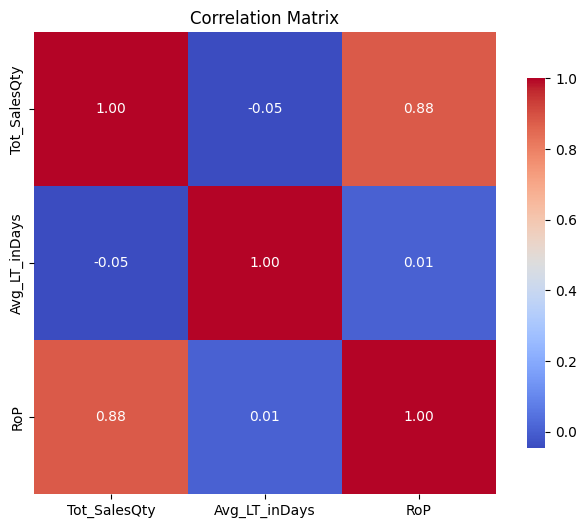

In [ ]:
correlation_data = RoP_Summary[['Tot_SalesQty', 'Avg_LT_inDays', 'RoP']]

correlation_matrix = correlation_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .8})
plt.title('Correlation Matrix')
plt.show()

# **Carrying Cost Analysis**

In [ ]:
print(endInv_df)

In [ ]:
annual_inventory_value= endInv_df.copy()
annual_inventory_value["total_value"]=(
    annual_inventory_value["onHand"]*annual_inventory_value["Price"]
)
brand_inventory_value= annual_inventory_value.groupby("Brand").agg(
    {"Price": "first", "Description": "first", "total_value":"sum","onHand":"sum"}
)
brand_inventory_value.sort_values("total_value",ascending=False, inplace=True)
brand_inventory_value["RPA"]=RoP_Summary["RoP"]
brand_inventory_value["total_value_if_RPA"]=(
    brand_inventory_value["RPA"]*brand_inventory_value["Price"]
)
brand_inventory_value["total_value_saved_if_RPA"]=(
    brand_inventory_value["total_value"] -brand_inventory_value["total_value_if_RPA"]
)
brand_inventory_value.dropna(inplace = True)

fig=go.Figure()
fig.add_trace(
    go.Histogram(
        x=brand_inventory_value["total_value"],
        name="end of year inventory",
        nbinsx=50,
    )
    )
fig.add_trace(
    go.Histogram(
        x= brand_inventory_value["total_value_if_RPA"],
        name="if follow reorder point/optimal level",
        nbinsx=50
    )
)
fig.update_yaxes(type="log")
fig.update_layout(
    title_text="Total Inventory Value Distribution",
    xaxis_title_text="Total inventory value",
    yaxis_title_text="Total number of brands",
    bargap = 0.2,
    bargroupgap=0.1
)

fig.show()

In [ ]:
print(brand_inventory_value)

In [ ]:
display(brand_inventory_value[['total_value','total_value_if_RPA','total_value_saved_if_RPA']].sum().apply(lambda x: f"${x:,.0f}").to_frame().T)
brand_inventory_value["total_value"] = brand_inventory_value["total_value"].apply(
    lambda x: f"${x:,.0f}"
)
brand_inventory_value["total_value_if_RPA"] = brand_inventory_value[
    "total_value_if_RPA"
].apply(lambda x: f"${x:,.0f}")
brand_inventory_value["total_value_saved_if_RPA"] = brand_inventory_value[
    "total_value_saved_if_RPA"
].apply(lambda x: f"${x:,.0f}")
display(brand_inventory_value.head(10), brand_inventory_value.tail(10))